In [659]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, calinski_harabasz_score, \
    davies_bouldin_score
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm_notebook
from get_metrics import get_metrics_classification

from umap import UMAP
from sklearn.manifold import TSNE

from sklearn.base import BaseEstimator

import warnings

warnings.filterwarnings("ignore")

RAND = 10

In [6]:
df = pd.read_csv('../data/df_labels_EDA.csv')

In [7]:
df

name  Принимает_у_себя  Выезд_к_клиенту  \
0                         Emil Mekhriev                 1                1   
1               Ирина Юрьевна Попенкова                 0                0   
2           Александр Юрьевич Иванченко                 0                0   
3             Максим Станиславович Юдин                 1                0   
4             Светлана Андреевна Орлова                 1                1   
...                                 ...               ...              ...   
1992      Наталья Григорьевна Трегубова                 1                1   
1993    Диана Александровна Гапсаламова                 0                1   
1994       Татьяна Владимировна Олийник                 1                1   
1995  Екатерина Александровна Субботина                 1                1   
1996       Дмитрий Анатольевич Микрюков                 0                0   

      Работает_удаленно  Носитель английского  стажировка в США  \
0                     1                     1                 0   
1                     1                     0                 0   
2                     1                     0                 0   
3                     1                     0                 1   
4                     1                     0                 0   
...                 ...                   ...               ...   
1992                  1                     0                 0   
1993                  1                     0                 0   
1994                  1                     0                 0   
1995                  1                     0                 0   
1996                  1                     0                 0   

      стажировка в Англии  переводчик  лингвист  подготовка_к_IELTS  ...  \
0                       0           0         0                   1  ...   
1                       0           0         1                   1  ...   
2                       0           1         0                   1  ...   
3                       0           1         1                   1  ...   
4                       0           0         0                   1  ...   
...                   ...         ...       ...                 ...  ...   
1992                    0           0         1                   0  ...   
1993                    0           0         0                   0  ...   
1994                    0           0         0                   0  ...   
1995                    0           1         1                   0  ...   
1996                    0           1         1                   0  ...   

      более_250_отзывов  менее_50_отзывов  ср_цена_1500-3500  ср_цена_<1500  \
0                     1                 0                  1              0   
1                     0                 0                  1              0   
2                     0                 0                  1              0   
3                     1                 0                  1              0   
4                     0                 0                  0              0   
...                 ...               ...                ...            ...   
1992                  0                 1                  1              0   
1993                  0                 1                  1              0   
1994                  0                 1                  0              1   
1995                  0                 1                  0              1   
1996                  0                 0                  0              1   

      ср_цена_>3500  уровень_знаний_подтверждён  нет_скидок  паспорт_проверен  \
0                 0                           1           1                 1   
1                 0                           1           1                 1   
2                 0                           1           1                 1   
3                 0                           0           0                 1   
4                 1       

In [8]:
df_cleaned = df.drop(columns=['name'])

# Снижение размерности

## UMAP

In [655]:
um = UMAP(n_components=2, random_state=RAND)
umap2_embedding = um.fit_transform(df_cleaned)

<Axes: >

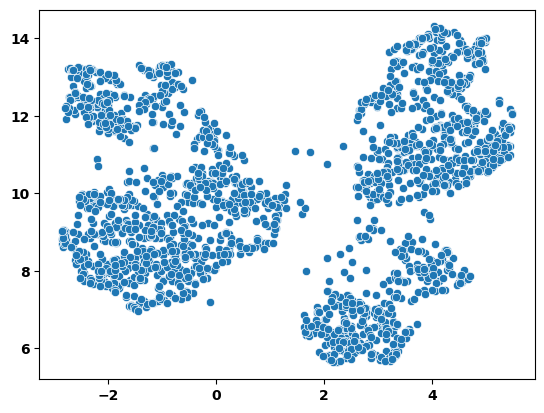

In [656]:
sns.scatterplot(x=umap2_embedding[:, 0], y=umap2_embedding[:, 1])

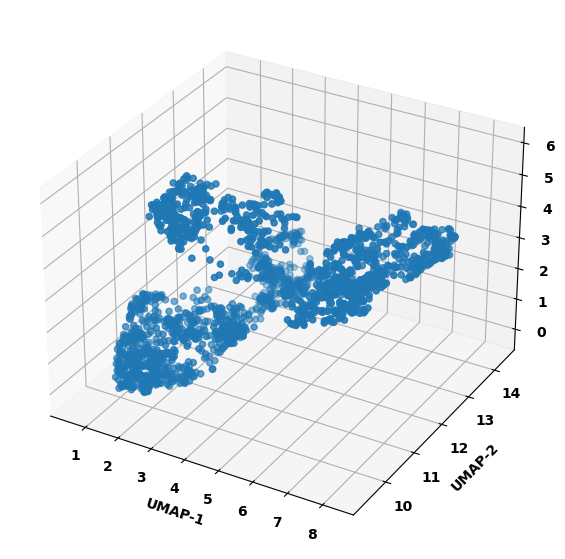

In [657]:
um3 = UMAP(n_components=3, random_state=RAND)
umap3_embedding = um3.fit_transform(df_cleaned)

ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
ax.scatter(xs=umap3_embedding[:, 0],
           ys=umap3_embedding[:, 1],
           zs=umap3_embedding[:, 2])
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
plt.show()

## T-SNE

In [27]:
tsne = TSNE(n_components=2, random_state=RAND)
tsne2_embedding = tsne.fit_transform(df_cleaned)

<Axes: >

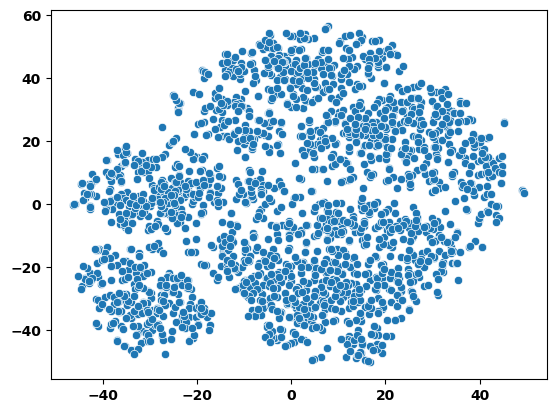

In [28]:
sns.scatterplot(x=tsne2_embedding[:, 0], y=tsne2_embedding[:, 1])

In [31]:
tsne3 = TSNE(n_components=3, random_state=RAND)
tsne3_embedding = tsne3.fit_transform(df_cleaned)

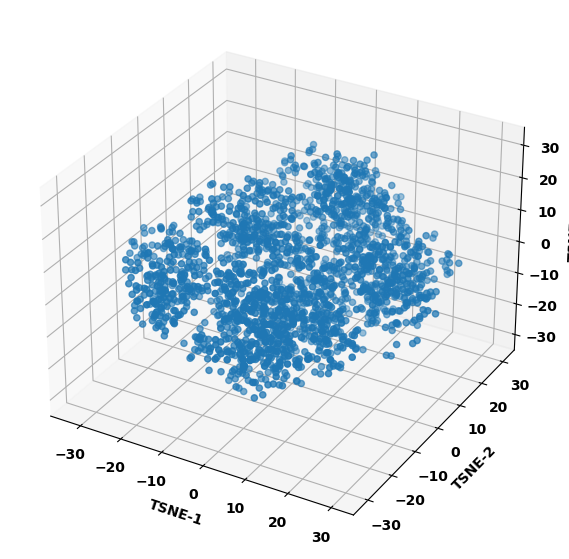

In [32]:
ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
ax.scatter(xs=tsne3_embedding[:, 0],
           ys=tsne3_embedding[:, 1],
           zs=tsne3_embedding[:, 2])
ax.set_xlabel('TSNE-1')
ax.set_ylabel('TSNE-2')
ax.set_zlabel('TSNE-3')
plt.show()

# Функции 

In [ ]:
def calculate_optimal_distance(list_clusters: list, list_score: list) -> float:
    """
    Поиск наибольшего расстояния для метода локтя
    :param list_clusters: количество кластеров
    :param list_score: параметры для подбора оптим кол-ва кластеров
    :return: максимальное расстояние
    """
    x1, y1 = list_clusters[0], list_score[0]
    x2, y2 = list_clusters[-1], list_score[-1]
    A, B, C = y1 - y2, x2 - x1, x1 * y2 - x2 * y1

    max_dist = -np.inf
    max_x = -np.inf
    for num, i in enumerate(list_score[1:-1]):
        x_0, y_0 = list_clusters[1:-1][num], list_score[1:-1][num]
        dist = abs(A * x_0 + B * y_0 + C) / np.sqrt(A**2 + B**2)

        if dist > max_dist:
            max_dist = dist
            max_x = x_0
        else:
            continue
    return max_dist, max_x


def elbow_picture(labels_std: list, labels_min: list, labels_max: list,
                  labels_median: list, type_optimal: list, min_size: int,
                  max_size: int) -> None:
    """
    Метод локтя
    Функция для вывода графика зависимостей стандартной ошибки, 
    минимального и максимального числа объектов от кол-ва кластеров
    :param labels_std: список значений стандартных ошибок
    :param labels_min: список мин-х значений для каждого кол-ва кластеров
    :param labels_max: список макс-х значений для каждого кол-ва кластеров
    :param labels_median: список медианных значений для каждого кол-ва кластеров
    :param type_optimal: по какому параметру подбираем оптим кол-во кластеров
    :param min_size: минимальное кол-во кластеров.
    :param max_size: максимальное кол-во кластеров.
    """

    _, opt_cluster = calculate_optimal_distance(range(min_size, max_size + 1),
                                                type_optimal)

    plt.figure(figsize=(8, 6))
    plt.plot(range(min_size, max_size + 1),
             labels_std,
             marker='s',
             color='green',
             label='std')
    plt.plot(range(min_size, max_size + 1),
             labels_min,
             marker='s',
             color='grey',
             linestyle='dashed',
             label='min')
    plt.plot(range(min_size, max_size + 1),
             labels_median,
             marker='o',
             color='skyblue',
             linestyle='dashed',
             label='median')
    plt.plot(range(min_size, max_size + 1),
             labels_max,
             marker='o',
             color='grey',
             linestyle='dashed',
             label='max')
    plt.xlabel('Кластер')
    plt.ylabel('Станд.ошибка / Мин.кластер / Median / Макс.кластер')
    plt.axvline(x=opt_cluster,
                color='black',
                label=f'optimal clust= {opt_cluster}',
                linestyle='dashed')
    plt.legend()
    plt.show()


def silhouette_plot(data: pd.DataFrame,
                    labels: pd.Series,
                    metric='euclidean',
                    ax=None) -> None:
    """
    Функция вывода графика силуэтного скора
    :param data: датасэт
    :param labels: метки кластеров
    :param metric: метрика для вычисления силуэтного скора
    :param ax: объект оси для рисования
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(7, 5)

    silhouette_vals = silhouette_samples(data, labels, metric=metric)

    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax.barh(range(y_lower, y_upper),
                cluster_silhouette_vals,
                edgecolor='none',
                height=1)
        ax.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Получение средней оценки силуэтного скора и построение графика
    avg_score = np.mean(silhouette_vals)
    ax.axvline(avg_score, linestyle='--', linewidth=1, color='red')
    ax.set_xlabel(f'Silhouette  = {round(avg_score,1)}')
    ax.set_ylabel('Метки кластеров')
    ax.set_title('График силуэта для различных кластеров', y=1.02)


def metric_picture(score_list: float,
                   min_size: int,
                   max_size: int,
                   name_metric,
                   optimal: bool = True) -> None:
    """
    Функция для вывода графика зависимости метрики от кол-ва кластеров
    :param score_list: значения метрики для каждого кол-ва кластеров
    :param min_size: минимальное кол-во кластеров
    :param max_size: Максимальное кол-во кластеров
    :param name_metric: название метрики
    :param optimal: отображение оптимального количества кластеров
    """
    plt.figure(figsize=(8, 6))
    if optimal:
        _, opt_cluster = calculate_optimal_distance(range(
            min_size, max_size + 1),
                                                    list_score=score_list)
        plt.plot(range(min_size, max_size + 1), score_list, marker='s')
        plt.axvline(x=opt_cluster,
                    color='black',
                    label=f'optimal clust= {opt_cluster}',
                    linestyle='dashed')
        plt.xlabel('$Clusters$')
        plt.ylabel(f'${name_metric}$')
    else:
        plt.plot(range(min_size, max_size + 1), score_list, marker='s')
        plt.xlabel('$Clusters$')
        plt.ylabel(f'${name_metric}$')
    plt.show()


def check_fullness(data: pd.DataFrame, labels: pd.Series) -> None:
    """
    Функция для проверки медианной заполненности кластера
    Для бинаризованных данных
    :param data: датасэт
    :param labels: метки кластеров
    """
    sums = []
    for label in np.unique(labels):
        # Находим медианную заполненность кластера
        cluster_quantile = data[labels == label].sum(axis=0).quantile(.5)
        sums.append(cluster_quantile)
    pd.DataFrame(sums).sort_values(by=[0]).plot(kind="barh", figsize=(8, 6))
    plt.title('Заполненность кластеров')
    plt.ylabel('clusters')
    plt.show()


def plot_size(data: pd.DataFrame, labels: pd.Series) -> None:
    """
    Фунция для вывода графика размера кластеров
    :param data: датасэт
    :param labels: метки кластеров.
    """
    plt.title('Размер кластеров')
    cluster_size = data.assign(
        cluster=labels).groupby('cluster').count().iloc[:, 0]
    cluster_size.sort_values().plot.barh(figsize=(6, 4), color='C0')
    plt.show()


def plot_top_features(data, labels, n_clusters) -> None:
    """
    ТОП признаков для бинаризованных данных
    :param data: датасэт
    :param labels: метки кластеров
    :param n_clusters: количество кластеров
    """
    binary_label = data.assign(cluster=labels)
    size_cluster = binary_label.groupby('cluster').count().iloc[:, 0]
    data_sum = binary_label.groupby('cluster').sum()
    data_sum_norm = data_sum.T / size_cluster

    fig, ax_lst = plt.subplots(n_clusters, 1, figsize=(6, n_clusters * 5))
    plt.subplots_adjust(wspace=0.8, hspace=0.3)
    for i in range(n_clusters):
        ax_lst.reshape(-1)[i].set_title('cluster = ' + str(i))
        data_sum_norm.loc[:, i].sort_values()[-10:].plot.barh(
            ax=ax_lst.reshape(-1)[i], color='C0')
    plt.show()

In [41]:
def silhouette_scorer(estimator: BaseEstimator, data: pd.DataFrame) -> float:
    """
    Расчёт silhouette score
    """
    labels = estimator.fit_predict(data)
    score = silhouette_score(data, labels)
    return score

In [42]:
def calinski_harabasz_scorer(estimator: BaseEstimator,
                             data: pd.DataFrame) -> float:
    """
    Расчёт индекса calinski_harabasz
    """
    labels = estimator.fit_predict(data)
    score = calinski_harabasz_score(data, labels)
    return score

In [43]:
def davies_bouldin_index(estimator: BaseEstimator,
                         data: pd.DataFrame) -> float:
    """
    Расчёт индекса davies_bouldin
    """
    labels = estimator.fit_predict(data)
    score = davies_bouldin_score(data, labels)
    return score

In [120]:
def save_metric(model_name: str, data: pd.DataFrame,
                labels: list) -> pd.DataFrame:
    """
    Таблица с метриками для кластеризации
    :param model_name: название модели
    :param data: датасэт
    :param labels: метки кластеров
    :return: датасэт с метриками 
    """
    df_metrics = pd.DataFrame()
    df_metrics['model'] = [model_name]
    df_metrics['silhouette'] = silhouette_score(data, labels)
    df_metrics['calinski-harabasz'] = calinski_harabasz_score(data, labels)
    df_metrics['davies-bouldin'] = davies_bouldin_score(data, labels)
    return df_metrics

In [ ]:
def top_features_by_categories(data: pd.DataFrame, n_clusters: int) -> None:
    """
    ТОП-признаков в каждом кластере
    :param data: датасэт
    :param n_clusters: количество кластеров
    """
    # кол-во эл-ов в каждом кластере
    size_cluster = data.groupby('target').count().iloc[:, 0]
    # кол-во элементов каждого признака в кластере
    data_sum = data.groupby('target').sum()
    data_sum_norm = data_sum.T / size_cluster

    fig, ax_lst = plt.subplots(n_clusters, 1, figsize=(6, n_clusters * 5))
    plt.subplots_adjust(wspace=0.8, hspace=0.3)
    for i in range(n_clusters):
        ax_lst.reshape(-1)[i].set_title(f'{i} кластер')
        data_sum_norm.loc[:, i].sort_values()[-15:].plot.barh(
            ax=ax_lst.reshape(-1)[i], color='maroon')
    plt.show()

# Кластеризация

## K-means

In [51]:
# silhouette
parameters_grid = {
    'n_clusters': [3, 4, 5],
    'init': ['k-means++', 'random'],
    'max_iter': [50, 100, 200],
    'n_init': [5, 10, 15],
    'algorithm': ["lloyd", "auto", "full", "elkan"],
    'random_state': [RAND]
}

clf_km = KMeans()
grid_cv = GridSearchCV(clf_km,
                       parameters_grid,
                       scoring=silhouette_scorer,
                       verbose=1)

In [52]:
%%time
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
CPU times: total: 56min 6s
Wall time: 5min 54s


GridSearchCV(estimator=KMeans(),
             param_grid={'algorithm': ['lloyd', 'auto', 'full', 'elkan'],
                         'init': ['k-means++', 'random'],
                         'max_iter': [50, 100, 200], 'n_clusters': [3, 4, 5],
                         'n_init': [5, 10, 15], 'random_state': [10]},
             scoring=<function silhouette_scorer at 0x000001C9BFB6CF40>,
             verbose=1)

In [53]:
print(f'Best parameters: {grid_cv.best_params_}')
print(f'Best score: {grid_cv.best_score_}')

Best parameters: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 50, 'n_clusters': 3, 'n_init': 15, 'random_state': 10}
Best score: 0.0813411184205873


In [59]:
# изменим scoring = silhouette на calinski
parameters_grid = {
    'n_clusters': [3, 4, 5],
    'init': ['k-means++', 'random'],
    'max_iter': [50, 100, 150],
    'n_init': [5, 10, 15, 20],
    'algorithm': ["lloyd", "auto", "full", "elkan"],
    'random_state': [RAND]
}

clf_km = KMeans()
grid_cv = GridSearchCV(clf_km,
                       parameters_grid,
                       scoring=calinski_harabasz_scorer,
                       verbose=1)

In [60]:
%%time
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
CPU times: total: 1h 19min 30s
Wall time: 9min 28s


GridSearchCV(estimator=KMeans(),
             param_grid={'algorithm': ['lloyd', 'auto', 'full', 'elkan'],
                         'init': ['k-means++', 'random'],
                         'max_iter': [50, 100, 150], 'n_clusters': [3, 4, 5],
                         'n_init': [5, 10, 15, 20], 'random_state': [10]},
             scoring=<function calinski_harabasz_scorer at 0x000001C9BFB6FE20>,
             verbose=1)

In [61]:
print(f'Best parameters: {grid_cv.best_params_}')
print(f'Best score: {grid_cv.best_score_}')

Best parameters: {'algorithm': 'elkan', 'init': 'random', 'max_iter': 50, 'n_clusters': 3, 'n_init': 20, 'random_state': 10}
Best score: 33.0327295457794


In [62]:
# изменим scoring = calinski на davies_bouldin
parameters_grid = {
    'n_clusters': [3, 4, 5],
    'init': ['k-means++', 'random'],
    'max_iter': [50, 100],
    'n_init': [10, 15, 20],
    'algorithm': ["lloyd", "auto", "full", "elkan"],
    'random_state': [RAND]
}

clf_km = KMeans()
grid_cv = GridSearchCV(clf_km,
                       parameters_grid,
                       scoring=davies_bouldin_index,
                       verbose=1)

In [63]:
%%time
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
CPU times: total: 46min 58s
Wall time: 5min 38s


GridSearchCV(estimator=KMeans(),
             param_grid={'algorithm': ['lloyd', 'auto', 'full', 'elkan'],
                         'init': ['k-means++', 'random'], 'max_iter': [50, 100],
                         'n_clusters': [3, 4, 5], 'n_init': [10, 15, 20],
                         'random_state': [10]},
             scoring=<function davies_bouldin_index at 0x000001C9C13289A0>,
             verbose=1)

In [71]:
print(f'Best parameters: {grid_cv.best_params_}')
print(f'Best score: {grid_cv.best_score_}')

Best parameters: {'algorithm': 'elkan', 'init': 'random', 'max_iter': 50, 'n_clusters': 3, 'n_init': 10, 'random_state': 10}
Best score: 2.8949782872675147


Сравним модели

In [667]:
# параметры от метрики silhouette_score
clf_km = KMeans(n_clusters=3,
                random_state=RAND,
                init='k-means++',
                max_iter=50,
                n_init=15,
                algorithm='lloyd')
labels_km = clf_km.fit_predict(df_cleaned)

In [670]:
metrics = save_metric('kmeans', df_cleaned, labels_km)
round(metrics.set_index('model'), 4)

silhouette  calinski-harabasz  davies-bouldin
model                                                
kmeans      0.0788           156.6863          2.9263

In [671]:
#параметры от метрики calinski-harabasz
clf_km = KMeans(n_clusters=3,
                random_state=RAND,
                init='k-means++',
                max_iter=50,
                n_init=20,
                algorithm='elkan')
labels_km = clf_km.fit_predict(df_cleaned)

In [672]:
metrics = metrics._append(save_metric('kmeans_CH', df_cleaned, labels_km),
                          ignore_index=True)
round(metrics.set_index('model'), 4)

silhouette  calinski-harabasz  davies-bouldin
model                                                   
kmeans         0.0788           156.6863          2.9263
kmeans_CH      0.0791           156.6973          2.9257

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 3')

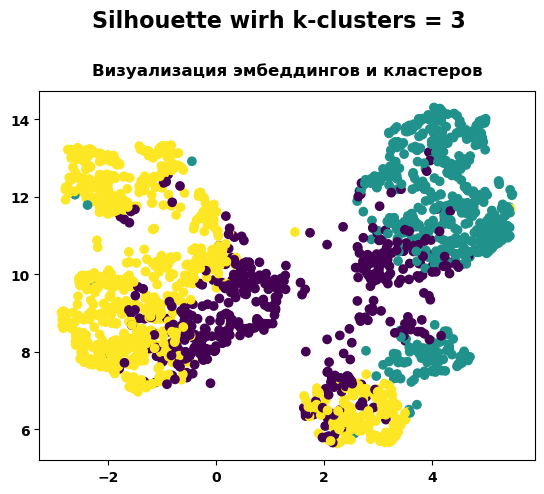

In [170]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels_km)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {3}',
             fontsize=16,
             y=1.05)

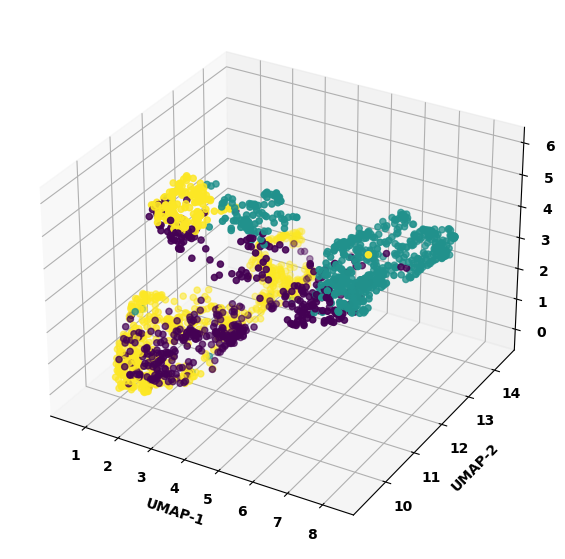

In [171]:
ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
ax.scatter(xs=umap3_embedding[:, 0],
           ys=umap3_embedding[:, 1],
           zs=umap3_embedding[:, 2],
           c=labels_km)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
plt.show()

## Spectral_clusterization

Сначала подберем примерный диапазон параметров, а затем сравним результаты с разными метриками

In [178]:
parameters_grid = {
    'n_clusters': [3, 4, 5],
    'affinity': ['nearest_neighbors', 'rbf'],
    'n_neighbors': [3, 4, 5, 8, 10],
    'gamma': [0.05, 0.09, 0.1, 0.2, 0.5],
    'assign_labels': ['kmeans', 'discretize'],
    'random_state': [RAND]
}

clf_spectral = SpectralClustering()
grid_cv_spec = GridSearchCV(clf_spectral,
                            parameters_grid,
                            scoring=silhouette_scorer,
                            verbose=1)

In [179]:
%%time
grid_cv_spec.fit(df_cleaned)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
CPU times: total: 1h 36min 21s
Wall time: 10min 55s


GridSearchCV(estimator=SpectralClustering(),
             param_grid={'affinity': ['nearest_neighbors', 'rbf'],
                         'assign_labels': ['kmeans', 'discretize'],
                         'gamma': [0.05, 0.09, 0.1, 0.2, 0.5],
                         'n_clusters': [3, 4, 5],
                         'n_neighbors': [3, 4, 5, 8, 10],
                         'random_state': [10]},
             scoring=<function silhouette_scorer at 0x000001C9BFB6CF40>,
             verbose=1)

In [180]:
print(f'Best parameters: {grid_cv_spec.best_params_}')
print(f'Best score: {grid_cv_spec.best_score_}')   

Best parameters: {'affinity': 'rbf', 'assign_labels': 'kmeans', 'gamma': 0.5, 'n_clusters': 3, 'n_neighbors': 3, 'random_state': 10}
Best score: 0.091123360148114


In [185]:
# изменим диапазон gamma и добавим пару параметров 
parameters_grid = {
    'n_clusters': [3, 4, 5],
    'eigen_solver': ['lobpcg'],
    'affinity': ['nearest_neighbors', 'rbf'],
    'n_neighbors': [3, 4, 5, 6],
    'gamma': [0.5, 0.8, 1.0, 1.5],
    'n_init': [5, 10, 15],
    'assign_labels': ['kmeans', 'discretize', 'cluster_qr'],
    'random_state': [RAND]
}

clf_spectral = SpectralClustering()
grid_cv_spec = GridSearchCV(clf_spectral,
                       parameters_grid,
                       scoring=silhouette_scorer,
                       verbose=1)

In [186]:
%%time
grid_cv_spec.fit(df_cleaned)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
CPU times: total: 3h 26min 31s
Wall time: 24min 37s


GridSearchCV(estimator=SpectralClustering(),
             param_grid={'affinity': ['nearest_neighbors', 'rbf'],
                         'assign_labels': ['kmeans', 'discretize',
                                           'cluster_qr'],
                         'eigen_solver': ['lobpcg'],
                         'gamma': [0.5, 0.8, 1.0, 1.5], 'n_clusters': [3, 4, 5],
                         'n_init': [5, 10, 15], 'n_neighbors': [3, 4, 5, 6],
                         'random_state': [10]},
             scoring=<function silhouette_scorer at 0x000001C9BFB6CF40>,
             verbose=1)

In [187]:
print(f'Best parameters: {grid_cv_spec.best_params_}')
print(f'Best score: {grid_cv_spec.best_score_}')  

Best parameters: {'affinity': 'rbf', 'assign_labels': 'kmeans', 'eigen_solver': 'lobpcg', 'gamma': 0.8, 'n_clusters': 3, 'n_init': 5, 'n_neighbors': 3, 'random_state': 10}
Best score: 0.0922387644968754


In [193]:
# изменим scoring silhouette на calinski
parameters_grid = {
    'n_clusters': [3, 4, 5],
    'eigen_solver': ['lobpcg'],
    'affinity': ['nearest_neighbors', 'rbf'],
    'n_neighbors': [3, 4, 5, 6],
    'gamma': [0.5, 0.8, 1.0, 1.5],
    'n_init': [5, 10, 15],
    'assign_labels': ['kmeans', 'discretize', 'cluster_qr'],
    'random_state': [RAND]
}

clf_spectral = SpectralClustering()
grid_cv_spec = GridSearchCV(clf_spectral,
                       parameters_grid,
                       scoring=calinski_harabasz_scorer,
                       verbose=1)

In [194]:
%%time
grid_cv_spec.fit(df_cleaned)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
CPU times: total: 3h 20min 40s
Wall time: 24min 2s


GridSearchCV(estimator=SpectralClustering(),
             param_grid={'affinity': ['nearest_neighbors', 'rbf'],
                         'assign_labels': ['kmeans', 'discretize',
                                           'cluster_qr'],
                         'eigen_solver': ['lobpcg'],
                         'gamma': [0.5, 0.8, 1.0, 1.5], 'n_clusters': [3, 4, 5],
                         'n_init': [5, 10, 15], 'n_neighbors': [3, 4, 5, 6],
                         'random_state': [10]},
             scoring=<function calinski_harabasz_scorer at 0x000001C9BFB6FE20>,
             verbose=1)

In [195]:
print(f'Best parameters: {grid_cv_spec.best_params_}')
print(f'Best score: {grid_cv_spec.best_score_}') 

Best parameters: {'affinity': 'rbf', 'assign_labels': 'discretize', 'eigen_solver': 'lobpcg', 'gamma': 0.5, 'n_clusters': 3, 'n_init': 5, 'n_neighbors': 3, 'random_state': 10}
Best score: 28.931307458362927


In [196]:
# изменим диапазон gamma
parameters_grid = {
    'n_clusters': [3, 4, 5],
    'eigen_solver': ['lobpcg'],
    'affinity': ['nearest_neighbors', 'rbf'],
    'n_neighbors': [3, 4, 5],
    'gamma': [0.05, 0.1, 0.5, 0.8, 1.0],
    'n_init': [5, 10, 15],
    'assign_labels': ['kmeans', 'discretize', 'cluster_qr'],
    'random_state': [RAND]
}

clf_spectral = SpectralClustering()
grid_cv_spec = GridSearchCV(clf_spectral,
                       parameters_grid,
                       scoring=calinski_harabasz_scorer,
                       verbose=1)

In [197]:
%%time
grid_cv_spec.fit(df_cleaned)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits
CPU times: total: 2h 58min 2s
Wall time: 20min 45s


GridSearchCV(estimator=SpectralClustering(),
             param_grid={'affinity': ['nearest_neighbors', 'rbf'],
                         'assign_labels': ['kmeans', 'discretize',
                                           'cluster_qr'],
                         'eigen_solver': ['lobpcg'],
                         'gamma': [0.05, 0.1, 0.5, 0.8, 1.0],
                         'n_clusters': [3, 4, 5], 'n_init': [5, 10, 15],
                         'n_neighbors': [3, 4, 5], 'random_state': [10]},
             scoring=<function calinski_harabasz_scorer at 0x000001C9BFB6FE20>,
             verbose=1)

In [198]:
print(f'Best parameters: {grid_cv_spec.best_params_}')
print(f'Best score: {grid_cv_spec.best_score_}')

Best parameters: {'affinity': 'rbf', 'assign_labels': 'kmeans', 'eigen_solver': 'lobpcg', 'gamma': 0.1, 'n_clusters': 3, 'n_init': 5, 'n_neighbors': 3, 'random_state': 10}
Best score: 31.929884830690128


In [203]:
# изменим диапазон gamma и n_init 
parameters_grid = {
    'n_clusters': [3, 4],
#     'eigen_solver': ['lobpcg'],
    'affinity': ['nearest_neighbors', 'rbf'],
    'n_neighbors': [3, 4],
    'gamma': [0.03, 0.05, 0.09, 0.1, 0.5],
    'n_init': [1, 2, 3, 4],
    'assign_labels': ['kmeans', 'discretize'],
    'random_state': [RAND]
}

clf_spectral = SpectralClustering()
grid_cv_spec = GridSearchCV(clf_spectral,
                            parameters_grid,
                            scoring=calinski_harabasz_scorer,
                            verbose=1)

In [204]:
%%time
grid_cv_spec.fit(df_cleaned)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
CPU times: total: 44min 19s
Wall time: 5min 8s


GridSearchCV(estimator=SpectralClustering(),
             param_grid={'affinity': ['nearest_neighbors', 'rbf'],
                         'assign_labels': ['kmeans', 'discretize'],
                         'gamma': [0.05, 0.09, 0.1, 0.5], 'n_clusters': [3, 4],
                         'n_init': [1, 2, 3, 4], 'n_neighbors': [3, 4],
                         'random_state': [10]},
             scoring=<function calinski_harabasz_scorer at 0x000001C9BFB6FE20>,
             verbose=1)

In [205]:
print(f'Best parameters: {grid_cv_spec.best_params_}')
print(f'Best score: {grid_cv_spec.best_score_}')

Best parameters: {'affinity': 'rbf', 'assign_labels': 'kmeans', 'gamma': 0.09, 'n_clusters': 3, 'n_init': 2, 'n_neighbors': 3, 'random_state': 10}
Best score: 31.942593326894915


In [673]:
# параметры от метрики silhouette_score
clf_spectral = SpectralClustering(n_clusters=3,
                                  n_neighbors=3,
                                  affinity='rbf',
                                  eigen_solver='lobpcg',
                                  assign_labels='kmeans',
                                  n_init=5,
                                  gamma=0.8,
                                  random_state=RAND)
labels_spectral = clf_spectral.fit_predict(df_cleaned)

In [674]:
metrics = metrics._append(save_metric('spectral', df_cleaned, labels_spectral),
                          ignore_index=True)
round(metrics.set_index('model'), 4)

silhouette  calinski-harabasz  davies-bouldin
model                                                   
kmeans         0.0788           156.6863          2.9263
kmeans_CH      0.0791           156.6973          2.9257
spectral       0.0931            38.2629          2.0377

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 3')

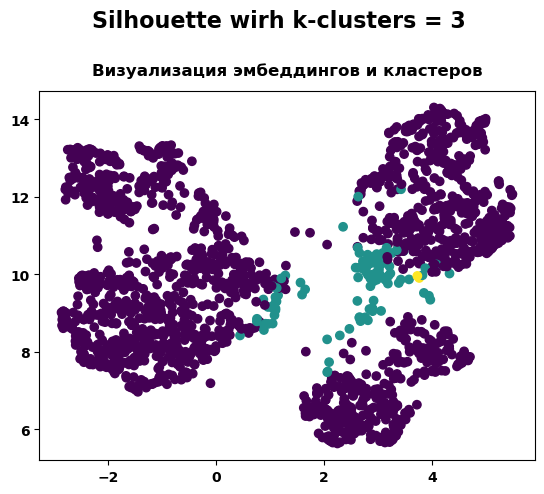

In [255]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels_spectral)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {3}',
             fontsize=16,
             y=1.05)

In [675]:
# параметры от метрики calinski-harabasz
clf_spectral = SpectralClustering(n_clusters=3,
                                  n_neighbors=3,
                                  eigen_solver='lobpcg',
                                  affinity='rbf',
                                  assign_labels='kmeans',
                                  n_init=2,
                                  gamma=0.09,
                                  random_state=RAND)
labels_spectral = clf_spectral.fit_predict(df_cleaned)

In [676]:
metrics = metrics._append(save_metric('spectral_CH', df_cleaned, labels_spectral),
                          ignore_index=True)

In [677]:
round(metrics.set_index('model'), 4)

silhouette  calinski-harabasz  davies-bouldin
model                                                     
kmeans           0.0788           156.6863          2.9263
kmeans_CH        0.0791           156.6973          2.9257
spectral         0.0931            38.2629          2.0377
spectral_CH      0.0757           153.8204          2.9548

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 3')

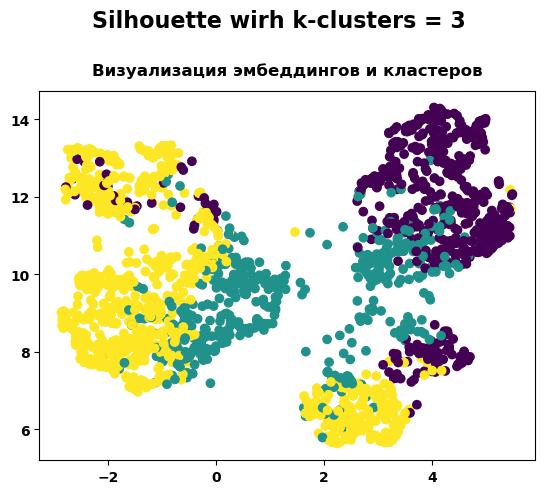

In [244]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels_spectral)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {3}',
             fontsize=16,
             y=1.05)

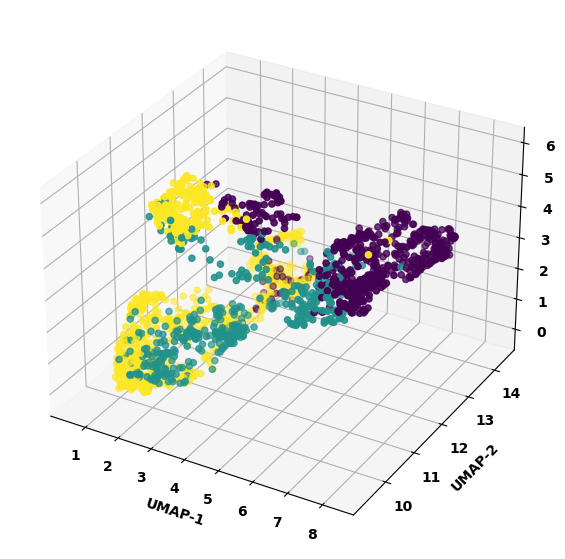

In [258]:
ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
ax.scatter(xs=um3_embedding[:, 0],
           ys=um3_embedding[:, 1],
           zs=um3_embedding[:, 2],
           c=labels_spectral)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
plt.show()

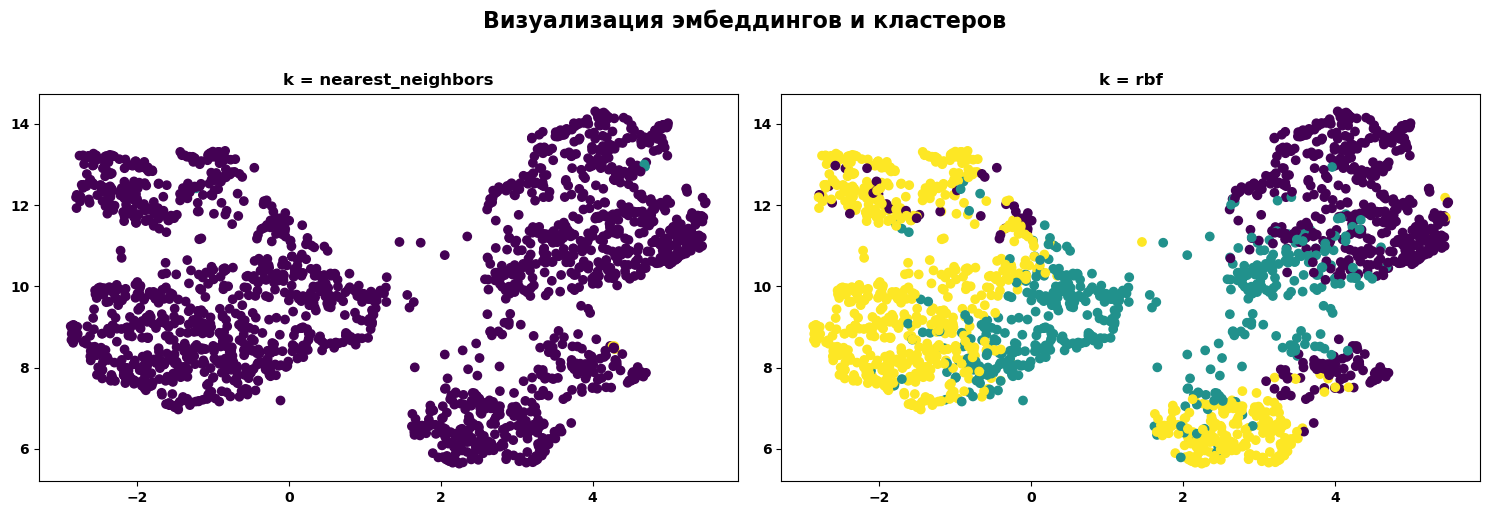

In [269]:
# как параметр affinity влияет на разбиение
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, k in enumerate(['nearest_neighbors', 'rbf']):
    clf_spectral = SpectralClustering(n_clusters=3,
                                      n_neighbors=3,
                                      eigen_solver='lobpcg',
                                      affinity=k,
                                      assign_labels='kmeans',
                                      n_init=2,
                                      gamma=0.09,
                                      random_state=RAND)
    labels_spectral = clf_spectral.fit_predict(df_cleaned)

    ax = axes[i]
    ax.scatter(clean_df_embedding[:, 0],
               clean_df_embedding[:, 1],
               c=labels_spectral)
    ax.set_title(f'k = {k}')

fig.suptitle('Визуализация эмбеддингов и кластеров',
             y=1.02,
             fontsize=16,
             fontweight='bold')
plt.tight_layout()
plt.show()

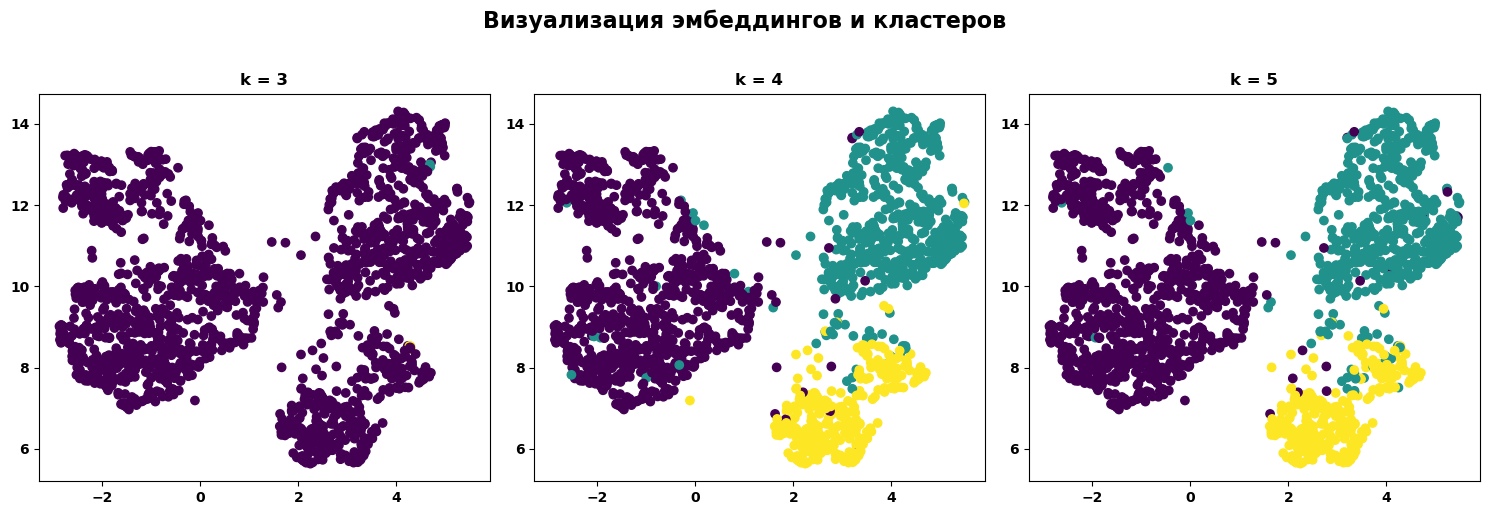

In [291]:
# как параметр n_neighbors влияет на разбиение (affinity = 'nearest_neighbors')
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, k in enumerate([3, 4, 5]):
    clf_spectral = SpectralClustering(n_clusters=3,
                                      n_neighbors=k,
                                      eigen_solver='lobpcg',
                                      affinity='nearest_neighbors',
                                      assign_labels='kmeans',
                                      n_init=2,
                                      gamma=0.09,
                                      random_state=RAND)
    labels_spectral = clf_spectral.fit_predict(df_cleaned)

    ax = axes[i]
    ax.scatter(clean_df_embedding[:, 0],
               clean_df_embedding[:, 1],
               c=labels_spectral)
    ax.set_title(f'k = {k}')

fig.suptitle('Визуализация эмбеддингов и кластеров',
             y=1.02,
             fontsize=16,
             fontweight='bold')
plt.tight_layout()
plt.show()

**Разный параметр affinity визуально дает абсолютно разное разделение по кластерам, при условии, что параметр n_neighbors для affinity = 'nearest_neighbors' также будет изменен.**

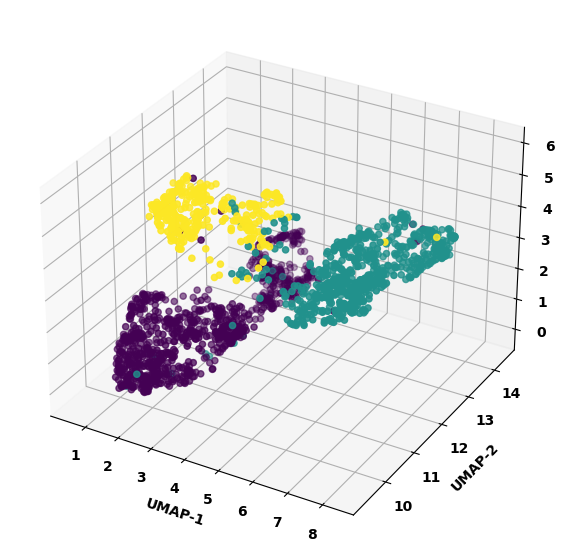

In [679]:
# изменим параметр n_neighbors
clf_spectral = SpectralClustering(n_clusters=3,
                                  n_neighbors=4,
                                  eigen_solver='lobpcg',
                                  affinity='nearest_neighbors',
                                  assign_labels='kmeans',
                                  n_init=2,
                                  gamma=0.09,
                                  random_state=RAND)
labels_spectral = clf_spectral.fit_predict(df_cleaned)

ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
ax.scatter(xs=um3_embedding[:, 0],
           ys=um3_embedding[:, 1],
           zs=um3_embedding[:, 2],
           c=labels_spectral)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
plt.show()

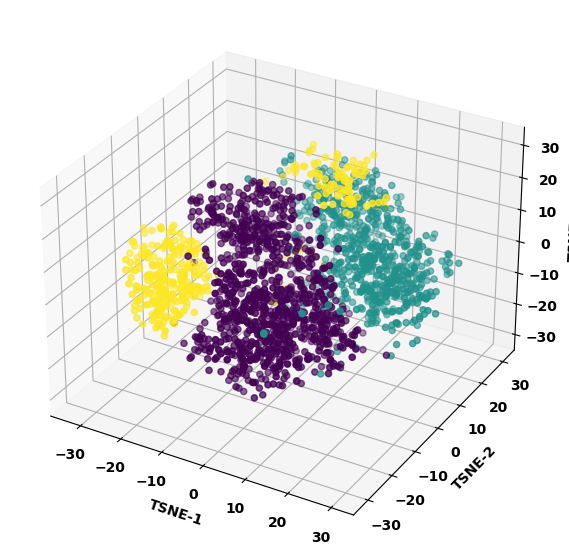

In [330]:
ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
ax.scatter(
    xs=tsne3_embedding[:, 0], 
    ys=tsne3_embedding[:, 1], 
    zs=tsne3_embedding[:, 2], 
    c=labels_spectral
)
ax.set_xlabel('TSNE-1')
ax.set_ylabel('TSNE-2')
ax.set_zlabel('TSNE-3')
plt.show()

**Такое разделение визуально является более хорошим, однако метрики calinski-harabasz и davies-bouldin немного ухудшаются (silhouette зачастую всегда +-0.01):**

In [680]:
metrics = metrics._append(save_metric('spectral_nearest_neig_3', df_cleaned,
                                       labels_spectral),
                          ignore_index=True)
round(metrics.set_index('model'), 4)

silhouette  calinski-harabasz  davies-bouldin
model                                                                 
kmeans                       0.0788           156.6863          2.9263
kmeans_CH                    0.0791           156.6973          2.9257
spectral                     0.0931            38.2629          2.0377
spectral_CH                  0.0757           153.8204          2.9548
spectral_nearest_neig_3      0.0800           133.6738          3.1210

Проверим также для n_clusters=4:

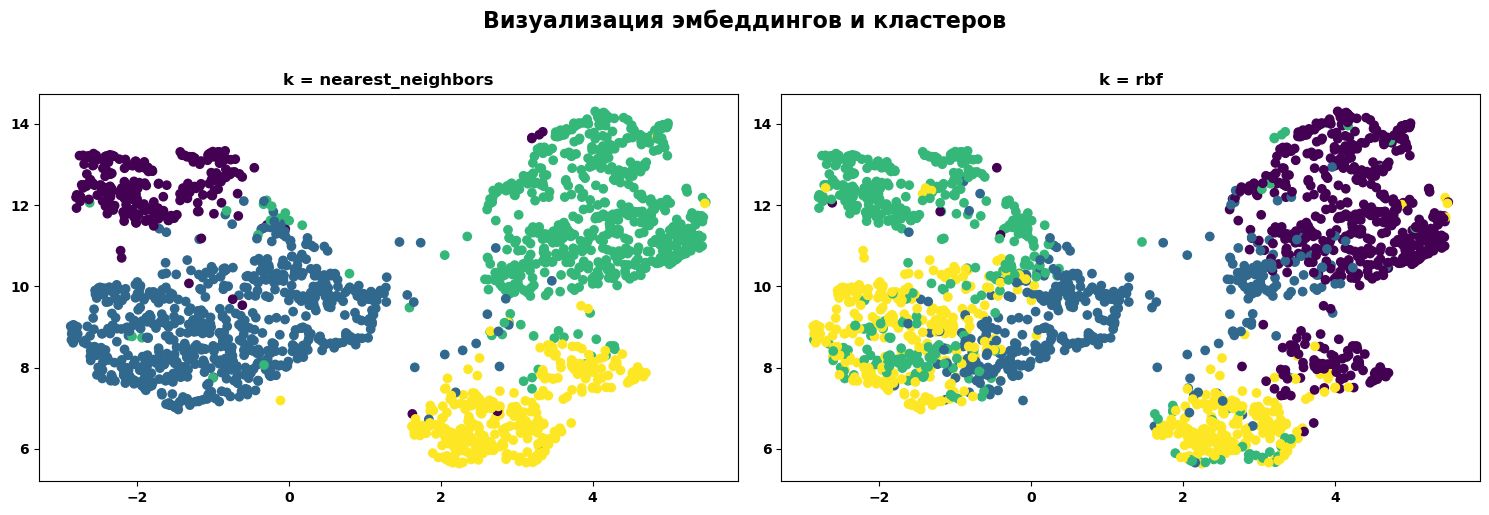

In [279]:
# как параметр affinity влияет на разбиение (n_clusters=4)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, k in enumerate(['nearest_neighbors', 'rbf']):
    clf_spectral = SpectralClustering(n_clusters=4,
                                      n_neighbors=4,
                                      affinity=k,
                                      assign_labels='kmeans',
                                      gamma=0.09,
                                      n_init=2,
                                      random_state=RAND)
    labels_spectral = clf_spectral.fit_predict(df_cleaned)

    ax = axes[i]
    ax.scatter(clean_df_embedding[:, 0],
               clean_df_embedding[:, 1],
               c=labels_spectral)
    ax.set_title(f'k = {k}')

fig.suptitle('Визуализация эмбеддингов и кластеров',
             y=1.02,
             fontsize=16,
             fontweight='bold')
plt.tight_layout()
plt.show()

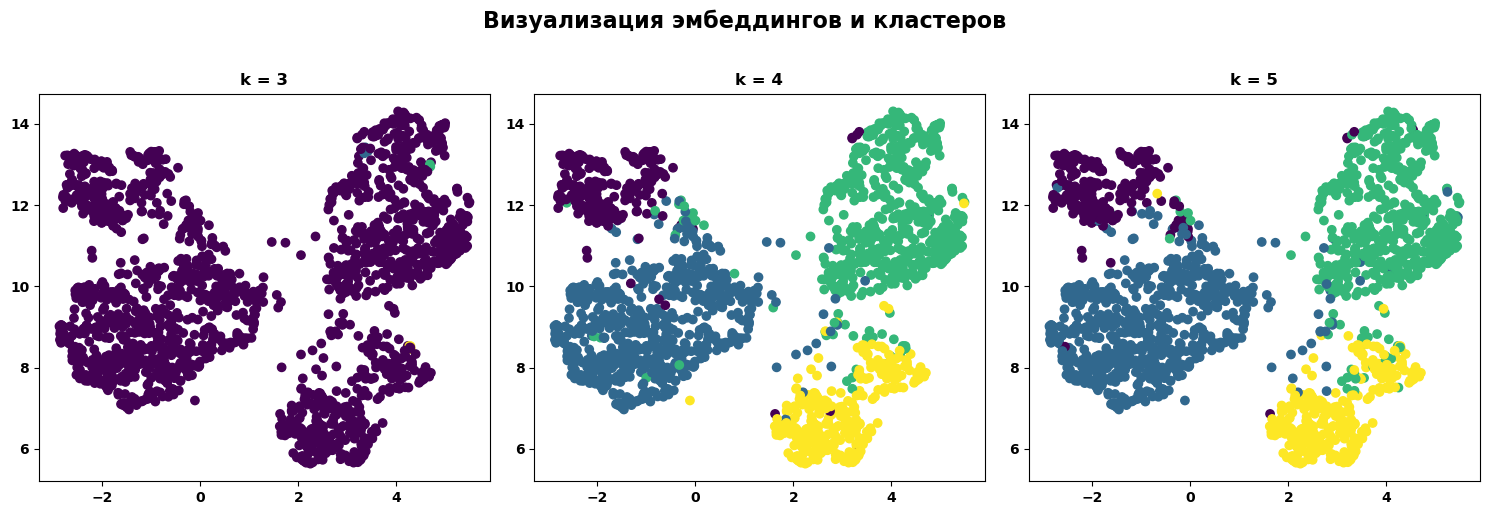

In [296]:
# Сравнение по значениям параметра n_neighbors
# Хорошее визуальное разбиение
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, k in enumerate([3, 4, 5]):
    clf_spectral = SpectralClustering(n_clusters=4,
                                      n_neighbors=k,
                                      affinity='nearest_neighbors',
                                      assign_labels='kmeans',
                                      gamma=0.09,
                                      n_init=2,
                                      random_state=RAND)
    labels_spectral = clf_spectral.fit_predict(df_cleaned)

    ax = axes[i]
    ax.scatter(clean_df_embedding[:, 0],
               clean_df_embedding[:, 1],
               c=labels_spectral)
    ax.set_title(f'k = {k}')

fig.suptitle('Визуализация эмбеддингов и кластеров',
             y=1.02,
             fontsize=16,
             fontweight='bold')
plt.tight_layout()
plt.show()

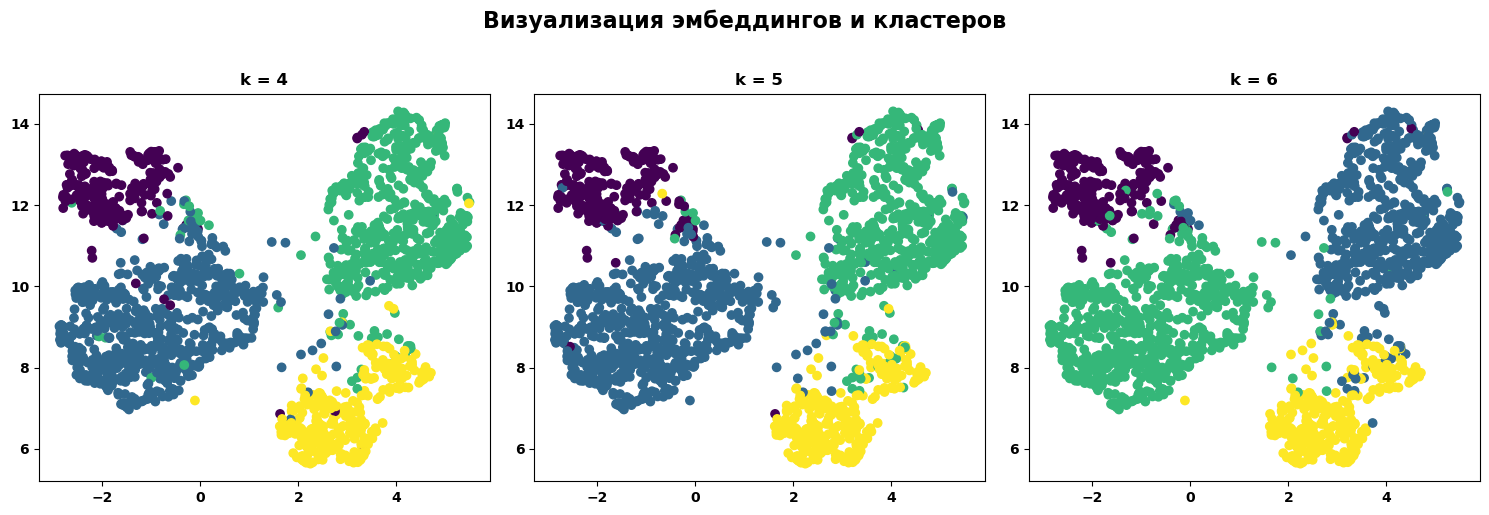

In [300]:
# Сравнение по значениям параметра n_neighbors
# Хорошее визуальное разбиение
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, k in enumerate([4, 5, 6]):
    clf_spectral = SpectralClustering(n_clusters=4,
                                      n_neighbors=k,
                                      affinity='nearest_neighbors',
                                      assign_labels='kmeans',
                                      gamma=0.09,
                                      n_init=2,
                                      random_state=RAND)
    labels_spectral = clf_spectral.fit_predict(df_cleaned)

    ax = axes[i]
    ax.scatter(clean_df_embedding[:, 0],
               clean_df_embedding[:, 1],
               c=labels_spectral)
    ax.set_title(f'k = {k}')

fig.suptitle('Визуализация эмбеддингов и кластеров',
             y=1.02,
             fontsize=16,
             fontweight='bold')
plt.tight_layout()
plt.show()

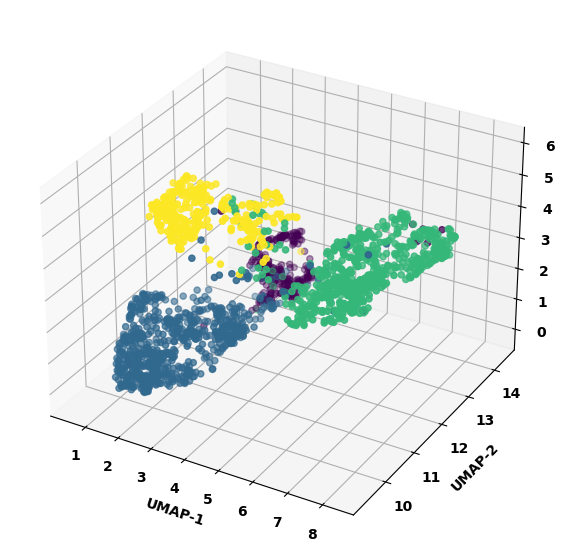

In [326]:
ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
ax.scatter(xs=um3_embedding[:, 0],
           ys=um3_embedding[:, 1],
           zs=um3_embedding[:, 2],
           c=labels_spectral)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
plt.show()

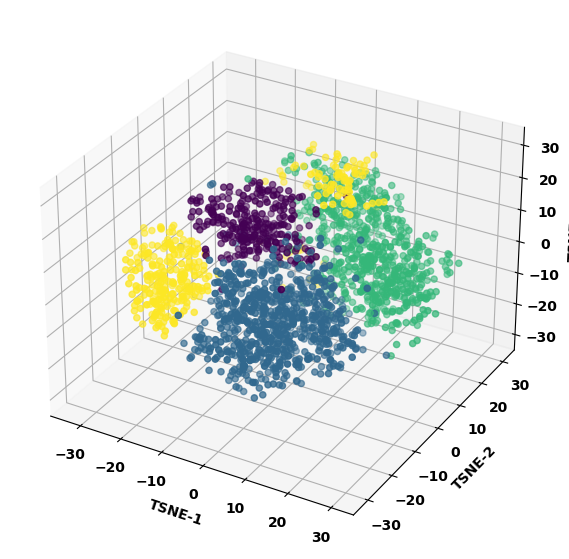

In [328]:
ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
ax.scatter(
    xs=tsne3_embedding[:, 0], 
    ys=tsne3_embedding[:, 1], 
    zs=tsne3_embedding[:, 2], 
    c=labels_spectral
)
ax.set_xlabel('TSNE-1')
ax.set_ylabel('TSNE-2')
ax.set_zlabel('TSNE-3')
plt.show()

In [681]:
clf_spectral = SpectralClustering(n_clusters=4,
                                  n_neighbors= 5,
                                  affinity='nearest_neighbors',
                                  assign_labels= 'kmeans',
                                  gamma=0.09,
                                  n_init=2,
                                  random_state=RAND)
labels_spectral = clf_spectral.fit_predict(df_cleaned)

metrics = metrics._append(save_metric('spectral_nearest_neig_4', df_cleaned,
                                       labels_spectral),
                          ignore_index=True)
round(metrics.set_index('model'), 4)

silhouette  calinski-harabasz  davies-bouldin
model                                                                 
kmeans                       0.0788           156.6863          2.9263
kmeans_CH                    0.0791           156.6973          2.9257
spectral                     0.0931            38.2629          2.0377
spectral_CH                  0.0757           153.8204          2.9548
spectral_nearest_neig_3      0.0800           133.6738          3.1210
spectral_nearest_neig_4      0.0444           117.8248          2.9902

Для n_clusters=4 метрики значительно упали, хотя davies-bouldin чуть улучшилась. Визуально же affinity='nearest_neighbors' показывает хорошие результаты при разделении как на 3 так и на 4 кластера.

После подбора параметров спектральная кластеризация в целом показала хороший результат

## Agglomerative

In [358]:
param_grid_aggl = {
    'n_clusters': [None, 3, 4, 5],
    'metric': ['euclidean', 'manhattan', 'cosine', 'l1', 'l2'],
    'linkage': ['ward', 'complete', 'average', 'single'],
    'distance_threshold': [0.05, 0.1, 0.5, 1.0, None],
}
clf_aggl = AgglomerativeClustering()
grid_cv_aggl = GridSearchCV(clf_aggl,
                       param_grid_aggl,
                       scoring=silhouette_scorer,
                       verbose=1)

In [359]:
%%time
grid_cv_aggl.fit(df_cleaned)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
CPU times: total: 4min 50s
Wall time: 55.5 s


GridSearchCV(estimator=AgglomerativeClustering(),
             param_grid={'distance_threshold': [0.05, 0.1, 0.5, 1.0, None],
                         'linkage': ['ward', 'complete', 'average', 'single'],
                         'metric': ['euclidean', 'manhattan', 'cosine', 'l1',
                                    'l2'],
                         'n_clusters': [None, 3, 4, 5]},
             scoring=<function silhouette_scorer at 0x000001C9BFB6CF40>,
             verbose=1)

In [360]:
print(f'Best parameters: {grid_cv_aggl.best_params_}')
print(f'Best score: {grid_cv_aggl.best_score_}') 

Best parameters: {'distance_threshold': None, 'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 3}
Best score: 0.13400566327305774


В описании к параметрам указано, что если 'metric': 'euclidean', то значение 'linkage' должно быть 'ward'. Однако при комбинации 'metric': 'euclidean', 'linkage': 'average' метрика показала самый высокий результат

In [345]:
# изменим scoring silhouette на calinski
param_grid_aggl = {
    'n_clusters': [None, 3, 4, 5],
    'metric': ['euclidean', 'manhattan', 'cosine', 'l1', 'l2'],
    'linkage': ['ward', 'complete', 'average', 'single'],
    'distance_threshold': [0.05, 0.1, 0.5, None],
}
clf_aggl = AgglomerativeClustering()
grid_cv_aggl = GridSearchCV(clf_aggl,
                       param_grid_aggl,
                       scoring=calinski_harabasz_scorer,
                       verbose=1)

In [346]:
%%time
grid_cv_aggl.fit(df_cleaned)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
CPU times: total: 41 s
Wall time: 41.5 s


GridSearchCV(estimator=AgglomerativeClustering(),
             param_grid={'distance_threshold': [0.05, 0.1, 0.5, None],
                         'linkage': ['ward', 'complete', 'average', 'single'],
                         'metric': ['euclidean', 'manhattan', 'cosine', 'l1',
                                    'l2'],
                         'n_clusters': [None, 3, 4, 5]},
             scoring=<function calinski_harabasz_scorer at 0x000001C9BFB6FE20>,
             verbose=1)

In [347]:
print(f'Best parameters: {grid_cv_aggl.best_params_}')
print(f'Best score: {grid_cv_aggl.best_score_}') 

Best parameters: {'distance_threshold': None, 'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 3}
Best score: 24.434148626157945


In [352]:
# изменим диапазон distance_threshold
param_grid_aggl = {
    'n_clusters': [None, 3, 4],
    'metric': ['euclidean', 'manhattan', 'cosine', 'l1', 'l2'],
    'linkage': ['ward', 'complete', 'average', 'single'],
    'distance_threshold': [0.5, 1.0, 2.0, 3.0, None],
}
clf_aggl = AgglomerativeClustering()
grid_cv_aggl = GridSearchCV(clf_aggl,
                            param_grid_aggl,
                            scoring=calinski_harabasz_scorer,
                            verbose=1)

In [353]:
%%time
grid_cv_aggl.fit(df_cleaned)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
CPU times: total: 39.1 s
Wall time: 39.4 s


GridSearchCV(estimator=AgglomerativeClustering(),
             param_grid={'distance_threshold': [0.5, 1.0, 2.0, 3.0, None],
                         'linkage': ['ward', 'complete', 'average', 'single'],
                         'metric': ['euclidean', 'manhattan', 'cosine', 'l1',
                                    'l2'],
                         'n_clusters': [None, 3, 4]},
             scoring=<function calinski_harabasz_scorer at 0x000001C9BFB6FE20>,
             verbose=1)

In [354]:
print(f'Best parameters: {grid_cv_aggl.best_params_}')
print(f'Best score: {grid_cv_aggl.best_score_}')

Best parameters: {'distance_threshold': None, 'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 3}
Best score: 24.434148626157945


In [355]:
# изменим n_clusters
param_grid_aggl = {
    'n_clusters': [None],
    'metric': ['euclidean', 'manhattan', 'cosine', 'l1', 'l2'],
    'linkage': ['ward', 'complete', 'average', 'single'],
    'distance_threshold': [0.5, 1.0, 2.0, 3.0, None],
}
clf_aggl = AgglomerativeClustering()
grid_cv_aggl = GridSearchCV(clf_aggl,
                            param_grid_aggl,
                            scoring=calinski_harabasz_scorer,
                            verbose=1)

In [356]:
%%time
grid_cv_aggl.fit(df_cleaned)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 27.2 s
Wall time: 27.5 s


GridSearchCV(estimator=AgglomerativeClustering(),
             param_grid={'distance_threshold': [0.5, 1.0, 2.0, 3.0, None],
                         'linkage': ['ward', 'complete', 'average', 'single'],
                         'metric': ['euclidean', 'manhattan', 'cosine', 'l1',
                                    'l2'],
                         'n_clusters': [None]},
             scoring=<function calinski_harabasz_scorer at 0x000001C9BFB6FE20>,
             verbose=1)

In [357]:
print(f'Best parameters: {grid_cv_aggl.best_params_}')
print(f'Best score: {grid_cv_aggl.best_score_}')

Best parameters: {'distance_threshold': 2.0, 'linkage': 'complete', 'metric': 'manhattan', 'n_clusters': None}
Best score: 16.612617726638558


In [682]:
#silhouette
clf_aggl_clust = AgglomerativeClustering(n_clusters=3,
                                         metric='euclidean',
                                         linkage='average')
aggl_labels = clf_aggl_clust.fit_predict(df_cleaned)

In [683]:
metrics = metrics._append(save_metric('agglomerative', df_cleaned,
                                       aggl_labels),
                          ignore_index=True)
round(metrics.set_index('model'), 4)

silhouette  calinski-harabasz  davies-bouldin
model                                                                 
kmeans                       0.0788           156.6863          2.9263
kmeans_CH                    0.0791           156.6973          2.9257
spectral                     0.0931            38.2629          2.0377
spectral_CH                  0.0757           153.8204          2.9548
spectral_nearest_neig_3      0.0800           133.6738          3.1210
spectral_nearest_neig_4      0.0444           117.8248          2.9902
agglomerative                0.1691             8.9239          1.4689

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 3')

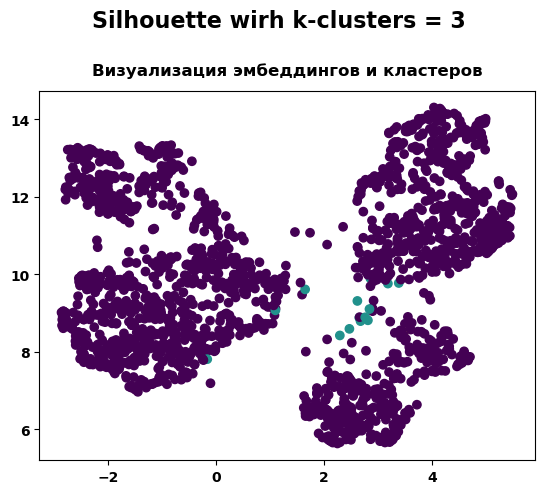

In [366]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=aggl_labels)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {3}',
             fontsize=16,
             y=1.05)

**Несмотря на высокий результат метрики silhouette_score (относительно прошлых результатов) визуально разделения на кластеры нет.**

In [684]:
# calinski-harabashz
clf_aggl_clust = AgglomerativeClustering(n_clusters=3,
                                         metric='euclidean',
                                         linkage='ward')
aggl_labels = clf_aggl_clust.fit_predict(df_cleaned)

In [685]:
metrics = metrics._append(save_metric('agglomerative_CH', df_cleaned,
                                       aggl_labels),
                          ignore_index=True)
round(metrics.set_index('model'), 4)

silhouette  calinski-harabasz  davies-bouldin
model                                                                 
kmeans                       0.0788           156.6863          2.9263
kmeans_CH                    0.0791           156.6973          2.9257
spectral                     0.0931            38.2629          2.0377
spectral_CH                  0.0757           153.8204          2.9548
spectral_nearest_neig_3      0.0800           133.6738          3.1210
spectral_nearest_neig_4      0.0444           117.8248          2.9902
agglomerative                0.1691             8.9239          1.4689
agglomerative_CH             0.0618           108.9213          3.5253

**Здесь мы видим, что при улучшении метрики silhouette_score улучшается и davies_bouldin, однако метрика calinski-harabasz становится в разы хуже и визуально кластеры не разделяются.**

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 3')

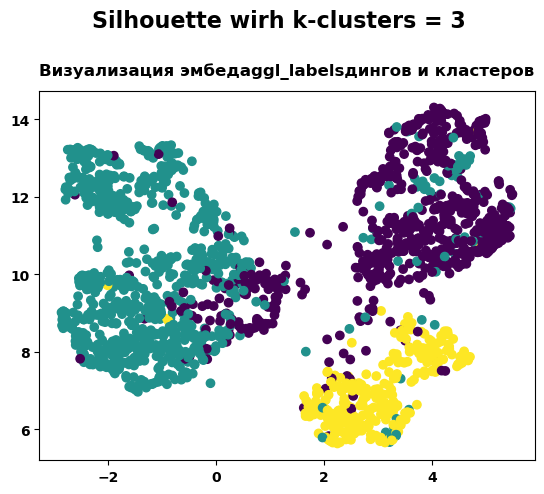

In [369]:
# agglomerative_CH
plt.scatter(clean_df_embedding[:, 0],
            clean_df_embedding[:, 1],
            c=aggl_labels)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {3}', fontsize=16, y=1.05)

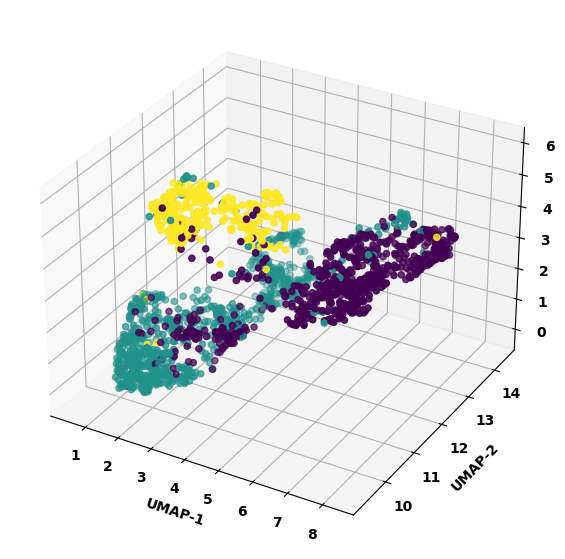

In [379]:
ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
ax.scatter(xs=umap3_embedding[:, 0],
           ys=umap3_embedding[:, 1],
           zs=umap3_embedding[:, 2],
           c=aggl_labels)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
plt.show()

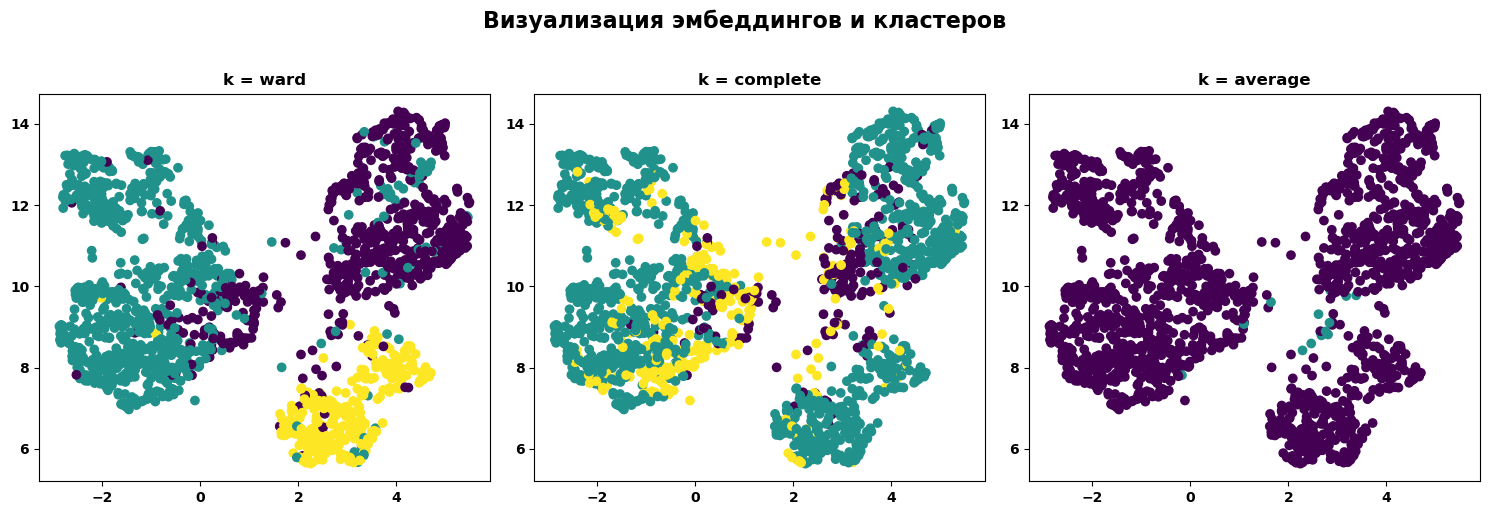

In [388]:
# как параметр linkage влияет на разбиение
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, k in enumerate(['ward', 'complete', 'average']):
    clf_aggl_clust = AgglomerativeClustering(n_clusters=3,
                                             affinity='euclidean',
                                             linkage=k)
    labels = clf_aggl_clust.fit_predict(df_cleaned)
    ax = axes[i]
    ax.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels)
    ax.set_title(f'k = {k}')

fig.suptitle('Визуализация эмбеддингов и кластеров',
             y=1.02,
             fontsize=16,
             fontweight='bold')
plt.tight_layout()
plt.show()

## GMM

In [489]:
# расширим диапазон tol
param_grid_gmm = {
    'n_components': [3, 4, 5],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'tol': [0.00001, 0.0001, 0.001, 0.01],
    'max_iter': [10, 30, 50],
    'init_params': ['kmeans', 'k-means++', 'random', 'random_from_data'],
    'random_state': [RAND]
}
gmm = GaussianMixture()
grid_cv_gmm = GridSearchCV(gmm,
                       param_grid_gmm,
                       scoring=calinski_harabasz_scorer,
                       verbose=1)

In [490]:
%%time
grid_cv_gmm.fit(df_cleaned)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
CPU times: total: 18min 18s
Wall time: 2min 13s


GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['full', 'tied', 'diag',
                                             'spherical'],
                         'init_params': ['kmeans', 'k-means++', 'random',
                                         'random_from_data'],
                         'max_iter': [10, 30, 50], 'n_components': [3, 4, 5],
                         'random_state': [10],
                         'tol': [1e-05, 0.0001, 0.001, 0.01]},
             scoring=<function calinski_harabasz_scorer at 0x000001C9BFB6FE20>,
             verbose=1)

In [491]:
print(f'Best parameters: {grid_cv_gmm.best_params_}')
print(f'Best score: {grid_cv_gmm.best_score_}')

Best parameters: {'covariance_type': 'spherical', 'init_params': 'random', 'max_iter': 50, 'n_components': 3, 'random_state': 10, 'tol': 0.0001}
Best score: 31.132540669511563


In [486]:
# изменим n_components и tol, добавим reg_covar
param_grid_gmm = {
    'n_components': [3, 4],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'reg_covar': [0.0001, 0.001, 0.005, 0.01, 0.05],
    'tol': [0.00001, 0.0005, 0.001, 0.005, 0.01],
    'max_iter': [20, 30],
    'init_params': ['kmeans', 'k-means++', 'random'],
    'random_state': [RAND]
}
gmm = GaussianMixture()
grid_cv_gmm = GridSearchCV(gmm,
                           param_grid_gmm,
                           scoring=calinski_harabasz_scorer,
                           verbose=1)

In [487]:
%%time
grid_cv_gmm.fit(df_cleaned)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
CPU times: total: 45min 15s
Wall time: 5min 8s


GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['full', 'tied', 'diag',
                                             'spherical'],
                         'init_params': ['kmeans', 'k-means++', 'random'],
                         'max_iter': [20, 30], 'n_components': [3, 4],
                         'random_state': [10],
                         'reg_covar': [0.0001, 0.001, 0.005, 0.01, 0.05],
                         'tol': [1e-05, 0.0005, 0.001, 0.005, 0.01]},
             scoring=<function calinski_harabasz_scorer at 0x000001C9BFB6FE20>,
             verbose=1)

In [488]:
print(f'Best parameters: {grid_cv_gmm.best_params_}')
print(f'Best score: {grid_cv_gmm.best_score_}')

Best parameters: {'covariance_type': 'spherical', 'init_params': 'random', 'max_iter': 30, 'n_components': 3, 'random_state': 10, 'reg_covar': 0.01, 'tol': 1e-05}
Best score: 31.786875107911648


In [687]:
# calinski-harabasz
gmm = GaussianMixture(n_components=3,
                      covariance_type='spherical',
                      init_params='random',
                      reg_covar=0.01,
                      max_iter=30,
                      tol=0.00001,
                      random_state=RAND)
labels_gmm = gmm.fit_predict(df_cleaned)

In [688]:
metrics = metrics._append(save_metric('GMM_CH', df_cleaned, labels_gmm),
                          ignore_index=True)
round(metrics.set_index('model'), 4)

silhouette  calinski-harabasz  davies-bouldin
model                                                                 
kmeans                       0.0788           156.6863          2.9263
kmeans_CH                    0.0791           156.6973          2.9257
spectral                     0.0931            38.2629          2.0377
spectral_CH                  0.0757           153.8204          2.9548
spectral_nearest_neig_3      0.0800           133.6738          3.1210
spectral_nearest_neig_4      0.0444           117.8248          2.9902
agglomerative                0.1691             8.9239          1.4689
agglomerative_CH             0.0618           108.9213          3.5253
GMM_CH                       0.0725           153.4222          2.9185

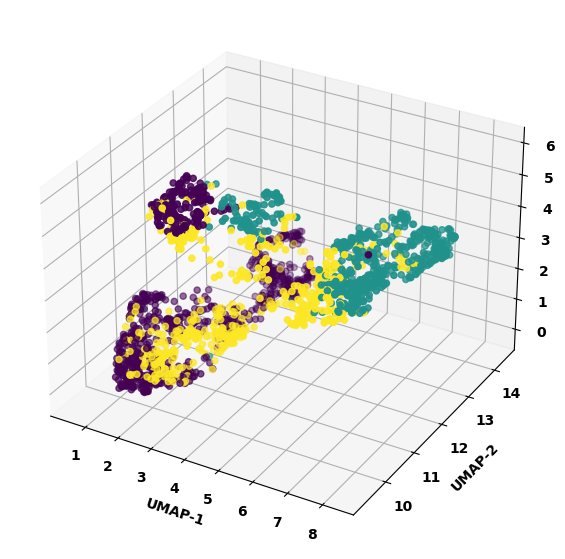

In [500]:
ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
ax.scatter(xs=um3_embedding[:, 0],
           ys=um3_embedding[:, 1],
           zs=um3_embedding[:, 2],
           c=labels_gmm)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
plt.show()

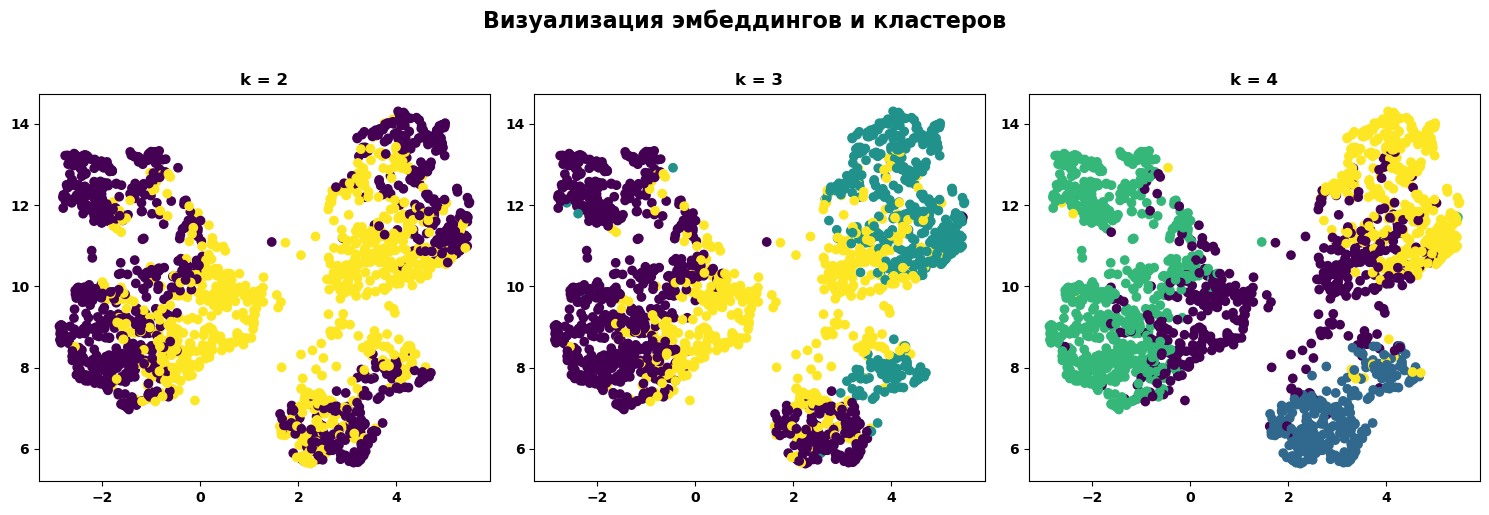

In [501]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, k in enumerate([2, 3, 4]):
    gmm = GaussianMixture(n_components=k,
                          covariance_type='spherical',
                          init_params='random',
                          reg_covar=0.01,
                          max_iter=30,
                          tol=0.00001,
                          random_state=RAND)
    labels = gmm.fit_predict(df_cleaned)
    ax = axes[i]
    ax.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels)
    ax.set_title(f'k = {k}')

fig.suptitle('Визуализация эмбеддингов и кластеров',
             y=1.02,
             fontsize=16,
             fontweight='bold')
plt.tight_layout()
plt.show()

**В нашем случае заданное кол-во смесей совпадает с кол-вом кластеров, которые находит GMM.**

## Voting

Тк к алгоритмам кластеризации не применяется стекинг и блэндинг, используем метод голосования, чтобы объединить результаты:

In [686]:
from scipy.stats import mode

In [689]:
kmeans = KMeans(n_clusters=3,
                random_state=RAND,
                init='k-means++',
                max_iter=50,
                n_init=20,
                algorithm='elkan')
spectral = SpectralClustering(n_clusters=3,
                              n_neighbors=4,
                              eigen_solver='lobpcg',
                              affinity='nearest_neighbors',
                              assign_labels='kmeans',
                              n_init=2,
                              gamma=0.09,
                              random_state=RAND)
agglomerative = AgglomerativeClustering(n_clusters=3,
                                        metric='euclidean',
                                        linkage='ward')
gmm = GaussianMixture(n_components=3,
                      covariance_type='spherical',
                      init_params='random',
                      reg_covar=0.01,
                      max_iter=30,
                      tol=0.00001,
                      random_state=RAND)

In [690]:
kmeans_labels = kmeans.fit_predict(df_cleaned)
agglomerative_labels = agglomerative.fit_predict(df_cleaned)
spectral_labels = spectral.fit_predict(df_cleaned)
gmm_labels = gmm.fit_predict(df_cleaned)

In [691]:
labels = np.array([kmeans_labels, agglomerative_labels, spectral_labels, gmm_labels])
# final_labels = mode(labels)[0][0]
final_labels = mode(labels)[0]

In [692]:
metrics = metrics._append(save_metric('Voting', df_cleaned, labels_gmm),
                          ignore_index=True)
round(metrics.set_index('model'), 4)

silhouette  calinski-harabasz  davies-bouldin
model                                                                 
kmeans                       0.0788           156.6863          2.9263
kmeans_CH                    0.0791           156.6973          2.9257
spectral                     0.0931            38.2629          2.0377
spectral_CH                  0.0757           153.8204          2.9548
spectral_nearest_neig_3      0.0800           133.6738          3.1210
spectral_nearest_neig_4      0.0444           117.8248          2.9902
agglomerative                0.1691             8.9239          1.4689
agglomerative_CH             0.0618           108.9213          3.5253
GMM_CH                       0.0725           153.4222          2.9185
Voting                       0.0725           153.4222          2.9185

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 3')

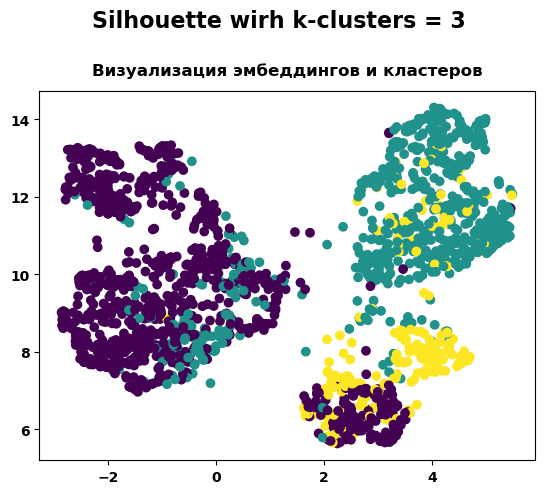

In [514]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=final_labels)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {3}',
             fontsize=16,
             y=1.05)

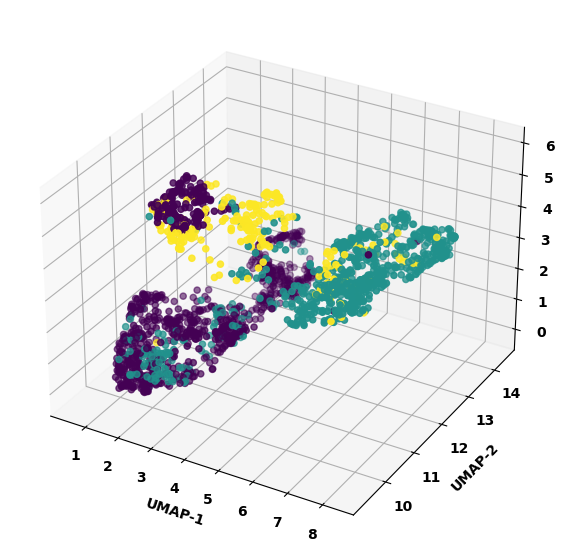

In [515]:
ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
ax.scatter(xs=um3_embedding[:, 0],
           ys=um3_embedding[:, 1],
           zs=um3_embedding[:, 2],
           c=final_labels)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
plt.show()

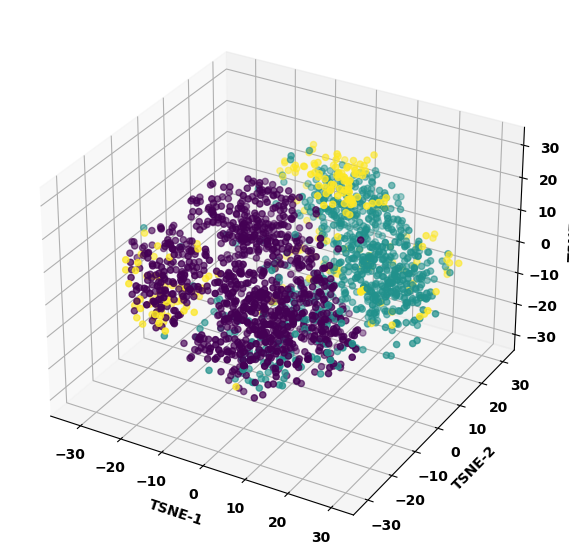

In [516]:
ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
ax.scatter(xs=tsne3_embedding[:, 0],
           ys=tsne3_embedding[:, 1],
           zs=tsne3_embedding[:, 2],
           c=final_labels)
ax.set_xlabel('TSNE-1')
ax.set_ylabel('TSNE-2')
ax.set_zlabel('TSNE-3')
plt.show()

## Конечная интерпретация

Для разделения на кластеры в данном проекте специально не рассматривалось кол-во кластеров равное 2, тк с точки зрения конечной интерпретации и визуализации (хоть она и имеет меньший вес при принятии решений) - 2 кластера несут мало смысла.

С учётом метрик (в основном calinski-harabasz) и визуализации были выбраны след. модели: 
- spectral_nearest_neig_3
- spectral_CH	

In [693]:
metrics

model  silhouette  calinski-harabasz  davies-bouldin
0                   kmeans    0.078756         156.686340        2.926305
1                kmeans_CH    0.079068         156.697264        2.925698
2                 spectral    0.093102          38.262949        2.037737
3              spectral_CH    0.075711         153.820411        2.954810
4  spectral_nearest_neig_3    0.080038         133.673755        3.121048
5  spectral_nearest_neig_4    0.044430         117.824837        2.990205
6            agglomerative    0.169062           8.923874        1.468912
7         agglomerative_CH    0.061840         108.921296        3.525282
8                   GMM_CH    0.072530         153.422228        2.918533
9                   Voting    0.072530         153.422228        2.918533

In [644]:
# spectral_nearest_neig_3
clf_spectral = SpectralClustering(n_clusters=3,
                                  n_neighbors=4,
                                  eigen_solver='lobpcg',
                                  affinity='nearest_neighbors',
                                  assign_labels='kmeans',
                                  n_init=2,
                                  gamma=0.09,
                                  random_state=RAND)
labels_spectral = clf_spectral.fit_predict(df_cleaned)

In [523]:
spectral_final = df_cleaned.assign(target=labels_spectral)
spectral_final['target'].value_counts()

target
0    990
1    664
2    343
Name: count, dtype: int64

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 3')

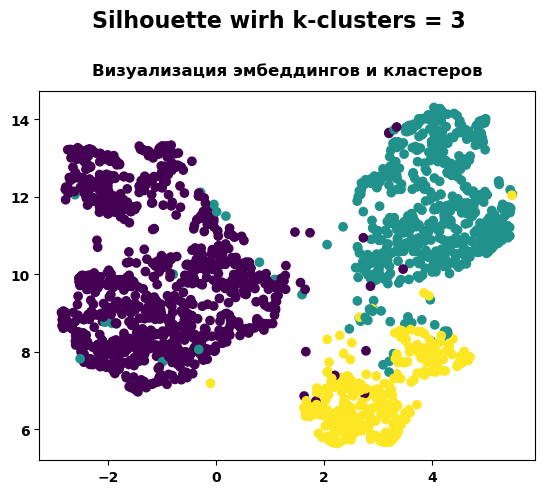

In [645]:
plt.scatter(clean_df_embedding[:, 0],
            clean_df_embedding[:, 1],
            c=labels_spectral)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {3}', fontsize=16, y=1.05)

In [524]:
count = spectral_final.groupby('target').count().iloc[:, :1].T.values
normalize = spectral_final.groupby('target').sum().T / count * 100

<Axes: xlabel='target'>

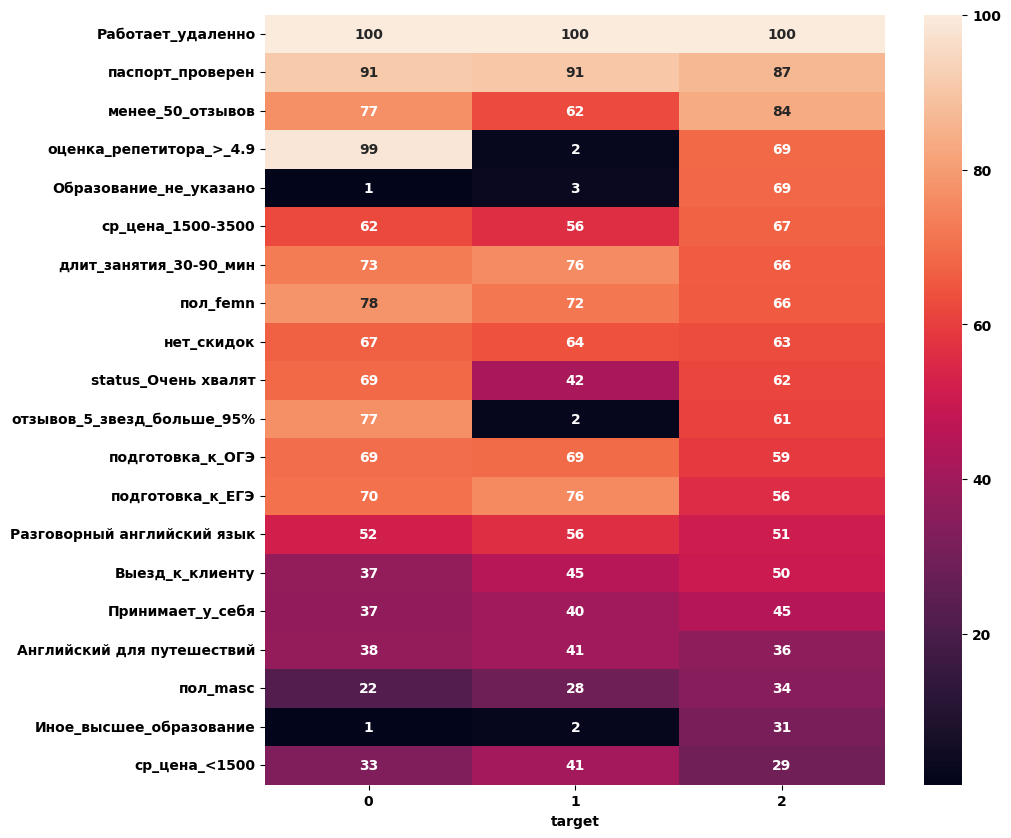

In [525]:
plt.figure(figsize=(10, 10))

sns.heatmap(normalize.sort_values(by=2, ascending=False)[:20],
            fmt='.0f',
            annot=True)

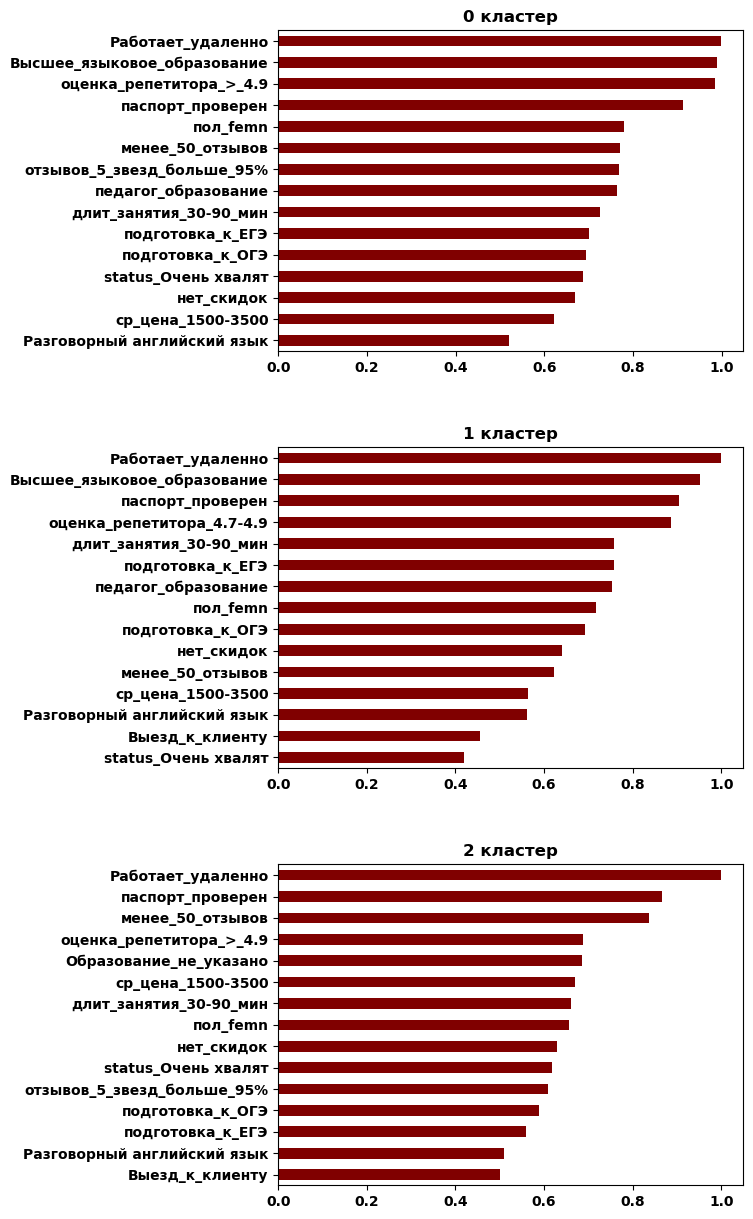

In [585]:
top_features_by_categories(spectral_final, 3)

кластер 0 - преобладают женщины, с высшим языковым образ-ем, очень высокие оценки, в меньшей степени специалист готов выезжать к клиенту;

кластер 1 - преобладают женщины, отсутствуют специалисты с лучшими оценками, репетиторы имеют высшее языковое образ-е и самые высокие оценки, работает в основном только удаленно;

кластер 2 - преобладают женщины, у многих специалистов образование не указано, большинство имеет менее 50 отзывов, также меньше специалистов готовятк ЕГЭ/ОГЭ;

**Возьмём также вариант модели, у которой визуальное разделение было не самым хорошим:**

In [650]:
# spectral_CH
clf_spectral = SpectralClustering(n_clusters=3,
                                  n_neighbors=3,
                                  eigen_solver='lobpcg',
                                  affinity='rbf',
                                  assign_labels='kmeans',
                                  n_init=2,
                                  gamma=0.09,
                                  random_state=RAND)
labels_spectral = clf_spectral.fit_predict(df_cleaned)

In [651]:
spectral_final_2 = df_cleaned.assign(target=labels_spectral)
spectral_final_2['target'].value_counts()

target
2    903
0    617
1    477
Name: count, dtype: int64

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 3')

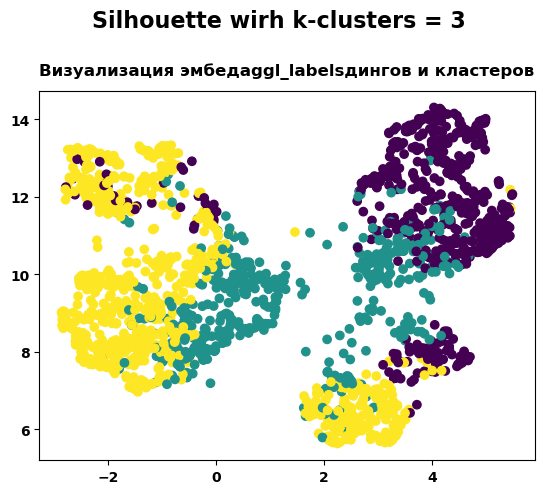

In [649]:
plt.scatter(clean_df_embedding[:, 0],
            clean_df_embedding[:, 1],
            c=labels_spectral)
plt.title('Визуализация эмбедaggl_labelsдингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {3}', fontsize=16, y=1.05)

In [652]:
count = spectral_final_2.groupby('target').count().iloc[:, :1].T.values
normalize = spectral_final_2.groupby('target').sum().T / count * 100

<Axes: xlabel='target'>

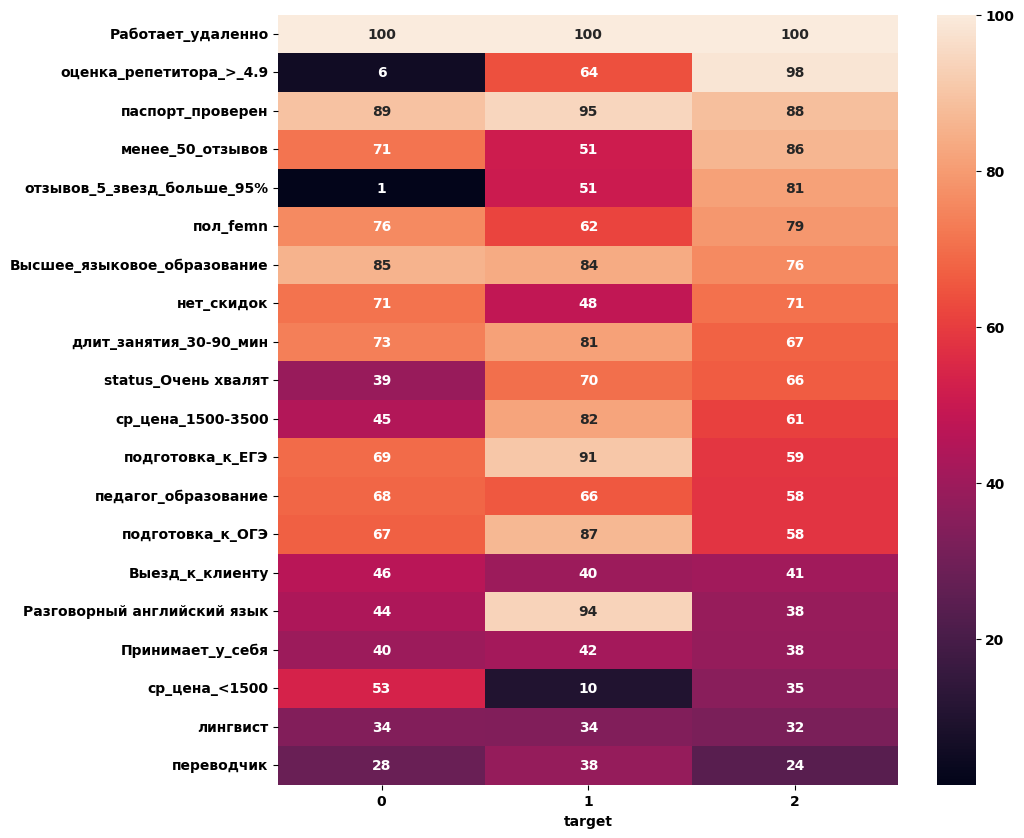

In [653]:
plt.figure(figsize=(10, 10))

sns.heatmap(normalize.sort_values(by=2, ascending=False)[:20],
            fmt='.0f',
            annot=True)

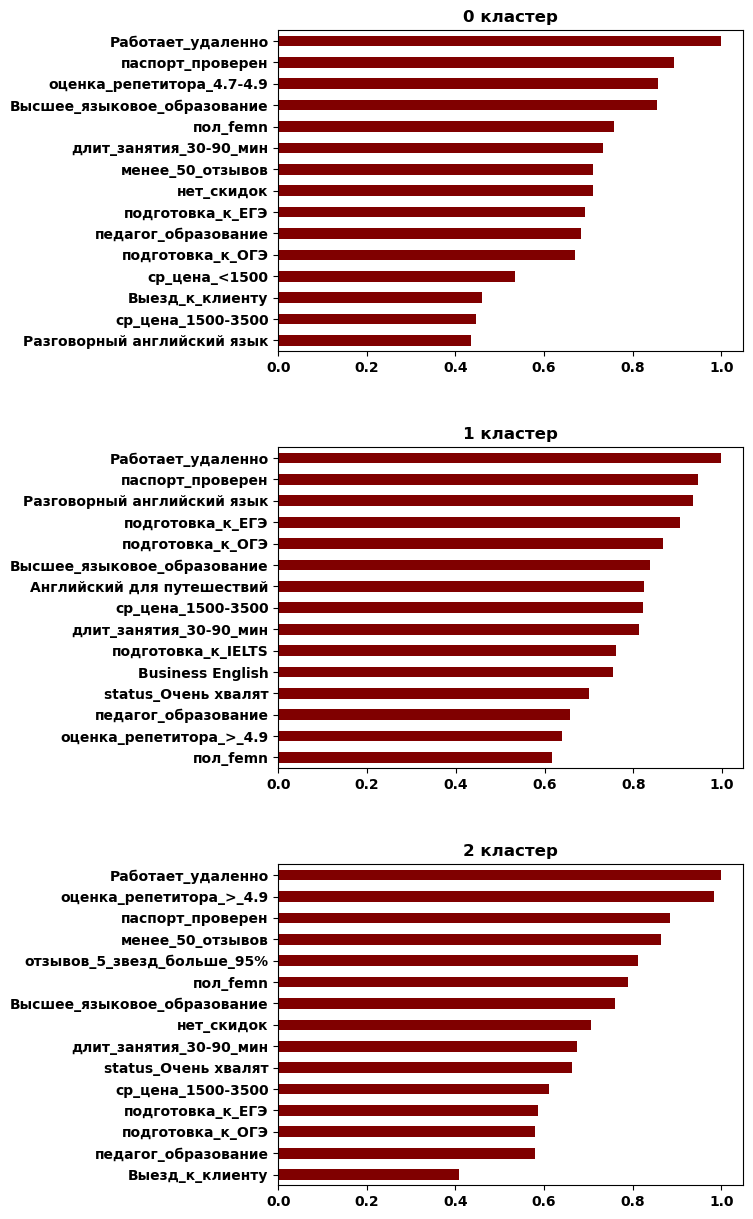

In [654]:
top_features_by_categories(spectral_final_2, 3)

кластер 0 - преобладают женщины, с высшим языковым образ-ем, нет очень высоких оценок, низкий и средний ценовой сегмент, зачастую отсутствуют скидки;

кластер 1 - среди специалистов чуть больше женщин, высшее языковое образ-е, средний ценовой сегмент, специализация - разговорный англ, ЕГЭ/ОГЭ, IELTS;

кластер 2 - преобладают женщины, высшее языковое образование, самые высокие оценки, мало отзывов, зачастую отсутствуют скидки;

**По результатам подбора параметров, с учётом всех критериев, лучше всего себя показала спектральная кластеризация. Kmeans также показала неплохой результат.**

**В результате выделить какие-то чёткие группы специалистов характерные каждому кластеру не совсем получилось. Возможно, это связано с тем, что собранные признаки в полной мере не отражают весь спектр навыков и характеристик специалистов. Для более чёткого разделения необходимо дополнить данные новыми признаками (не на основе старых) и удалить некоторые из старых признаков, которые для конечной интерпретации по итогу несут мало смысла**